# Problem Statement:  Perform clustering (Hierarchical,K means clustering and DBSCAN) for the airlines data to obtain optimum number of clusters

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score as sil, calinski_harabasz_score as chs, silhouette_samples

In [2]:
# Supressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data display customization

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [4]:
# Importing dataset
data = pd.read_excel('EastWestAirlines.xlsx',sheet_name='data')

# Column rename.
data.rename(columns={'ID#':'ID', 'Award?':'Award'}, inplace=True)

#Set ID as Index Column
data.set_index('ID',inplace=True,)
data

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
1,28143,0,1,1,1,174,1,0,0,7000,0
2,19244,0,1,1,1,215,2,0,0,6968,0
3,41354,0,1,1,1,4123,4,0,0,7034,0
4,14776,0,1,1,1,500,1,0,0,6952,0
5,97752,0,4,1,1,43300,26,2077,4,6935,1
...,...,...,...,...,...,...,...,...,...,...,...
4017,18476,0,1,1,1,8525,4,200,1,1403,1
4018,64385,0,1,1,1,981,5,0,0,1395,1
4019,73597,0,3,1,1,25447,8,0,0,1402,1


# 1.1 Data Description:

The file EastWestAirlinescontains information on passengers who belong to an airline’s frequent flier program. For each passenger the data include information on their mileage history and on different ways they accrued or spent miles in the last year. The goal is to try to identify clusters of passengers that have similar characteristics for the purpose of targeting different segments for different types of mileage offers

ID --Unique ID

Balance--Number of miles eligible for award travel

Qual_mile--Number of miles counted as qualifying for Topflight status

cc1_miles -- Number of miles earned with freq. flyer credit card in the past 12 months:

cc2_miles -- Number of miles earned with Rewards credit card in the past 12 months:

cc3_miles -- Number of miles earned with Small Business credit card in the past 12 months:

Note:

 1 = under 5,000

 2 = 5,000 - 10,000

 3 = 10,001 - 25,000

 4 = 25,001 - 50,000

 5 = over 50,000

Bonus_miles--Number of miles earned from non-flight bonus transactions in the past 12 months

Bonus_trans--Number of non-flight bonus transactions in the past 12 months

Flight_miles_12mo--Number of flight miles in the past 12 months

Flight_trans_12--Number of flight transactions in the past 12 months

Days_since_enrolled--Number of days since enrolled in flier program

Award--whether that person had award flight (free flight) or not

# 2. Data Exploration

**Descriptive Statistics**

In [5]:
data.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
count,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 1 to 4021
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles          3999 non-null   int64
 3   cc2_miles          3999 non-null   int64
 4   cc3_miles          3999 non-null   int64
 5   Bonus_miles        3999 non-null   int64
 6   Bonus_trans        3999 non-null   int64
 7   Flight_miles_12mo  3999 non-null   int64
 8   Flight_trans_12    3999 non-null   int64
 9   Days_since_enroll  3999 non-null   int64
 10  Award              3999 non-null   int64
dtypes: int64(11)
memory usage: 374.9 KB


In [7]:
# different cc_miles have different max values.
# so, we want to check what values these columns can take

print('unique_cc1',data.cc1_miles.unique())
print('unique_cc2',data.cc2_miles.unique())
print('unique_cc3',data.cc3_miles.unique())

unique_cc1 [1 4 3 2 5]
unique_cc2 [1 2 3]
unique_cc3 [1 3 2 4 5]


# 2.1 Missing Values

In [8]:
# As a part of the Data cleansing we check the data for any missing/ na values
# null count for columns

null_count_col = data.isnull().sum().value_counts(ascending=False)

# null percentage for columns

null_percent_col = (data.isnull().sum() * 100 / len(data)).value_counts(ascending=False)

print("Null Count for Columns:\n\n", null_count_col, "\n")
print("Null Percentage for Columns:\n\n", null_percent_col)

Null Count for Columns:

 0    11
dtype: int64 

Null Percentage for Columns:

 0.0    11
dtype: int64


In [9]:
# null count for rows

null_count_row = data.isnull().sum(axis=1).value_counts(ascending=False)

# null percentage for rows

null_percent_row = (data.isnull().sum(axis=1) * 100 / len(data)).value_counts(ascending=False)

print("Null Count for Rows:\n\n", null_count_row, "\n")
print("Null Percentage for Rows:\n\n", null_percent_row)

Null Count for Rows:

 0    3999
dtype: int64 

Null Percentage for Rows:

 0.0    3999
dtype: int64


**Duplicated Values**

print the duplicated rows

In [10]:
#data[data.duplicated()]

In [11]:
#data.drop_duplicates(inplace=True)
#data.duplicated().sum()
#data[data.duplicated()]
#data.shape

We removed the missing / Null and Duplicated values either in columns or rows, so we can move on to the next step, which is Exploratory Data Analysis.

# 3. Exploratory Data Analysis



Lets analyze the features by creating histograms to understand the distribution

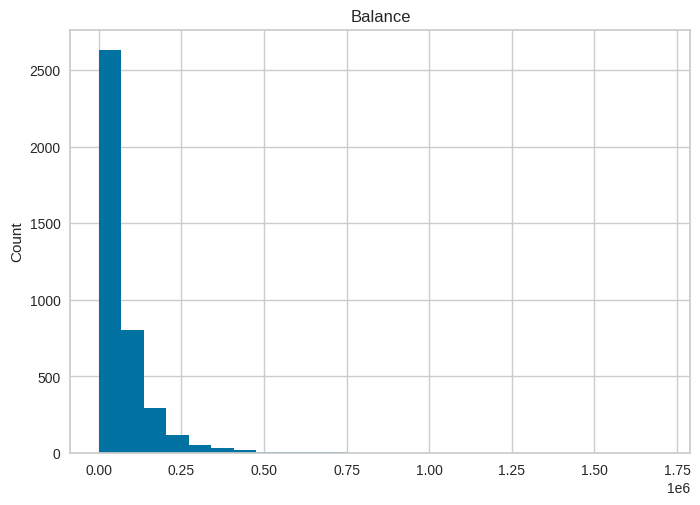

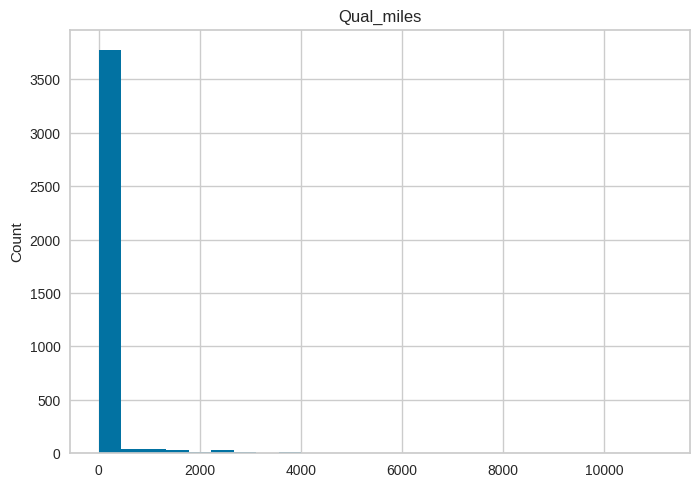

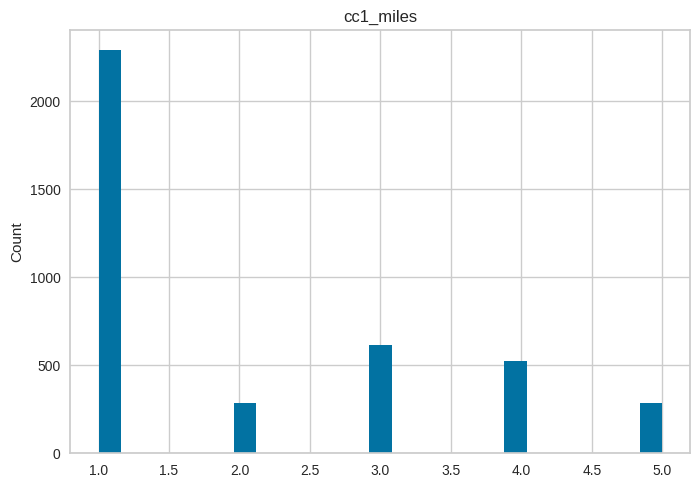

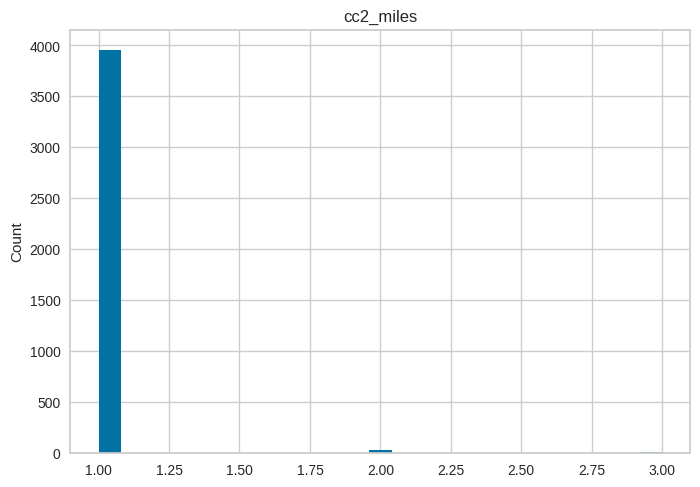

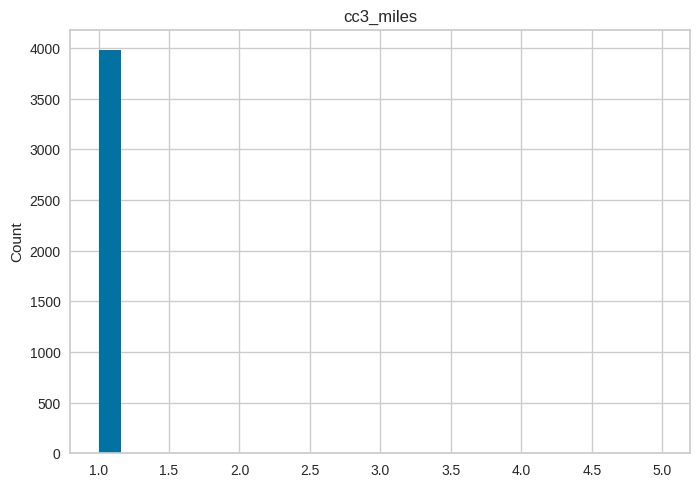

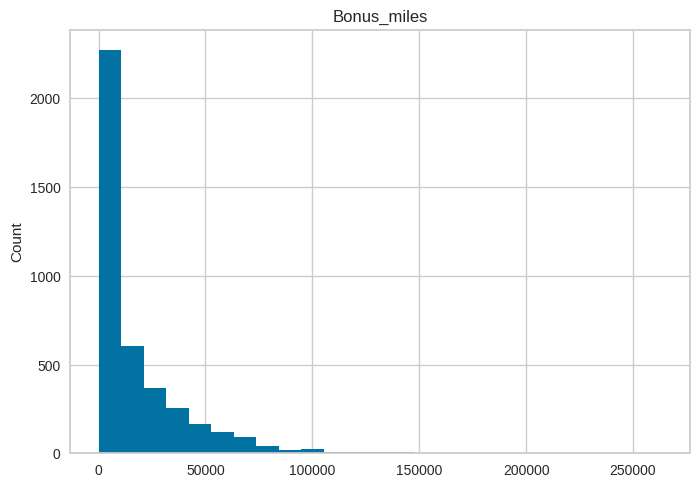

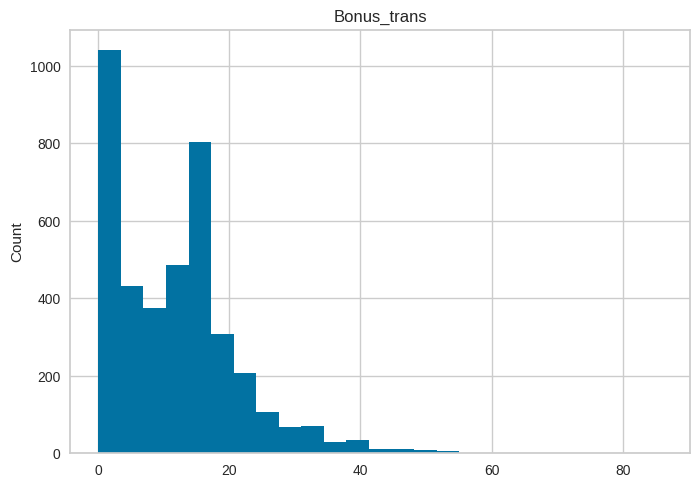

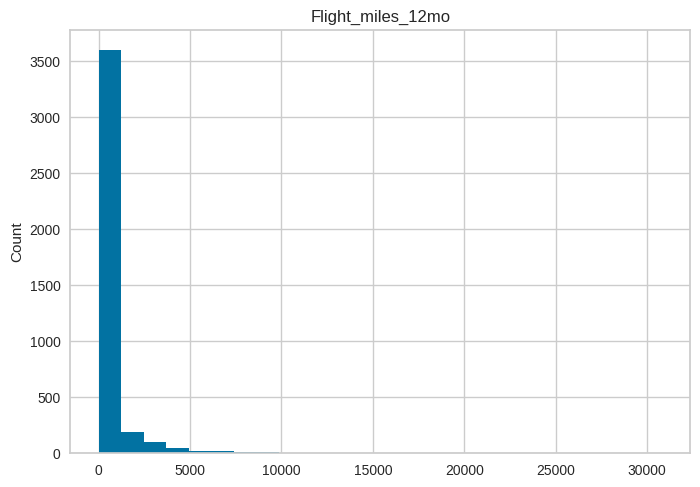

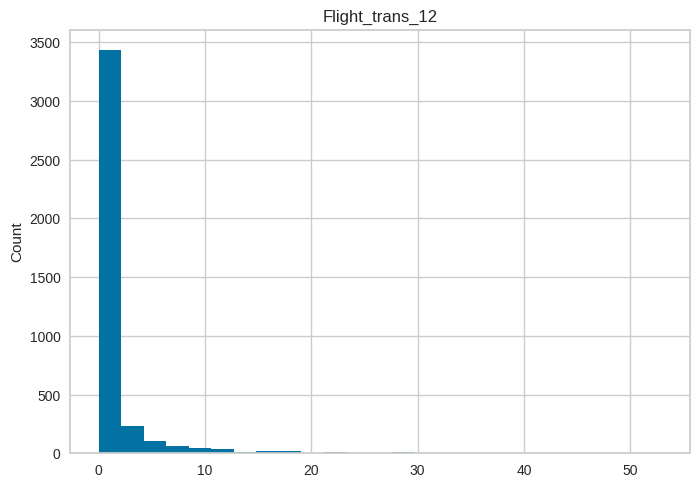

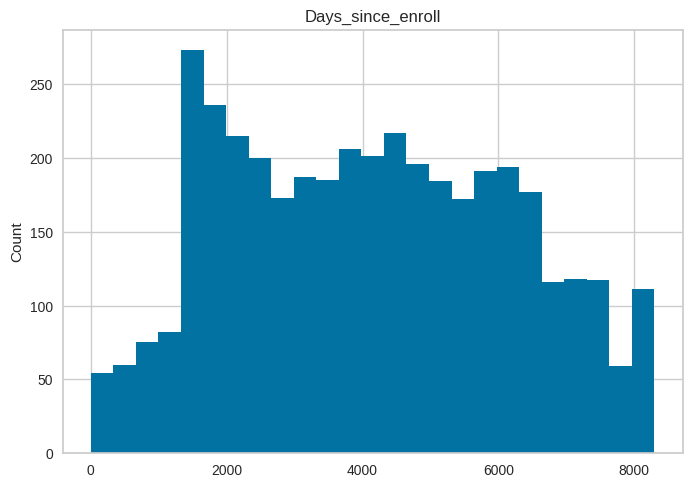

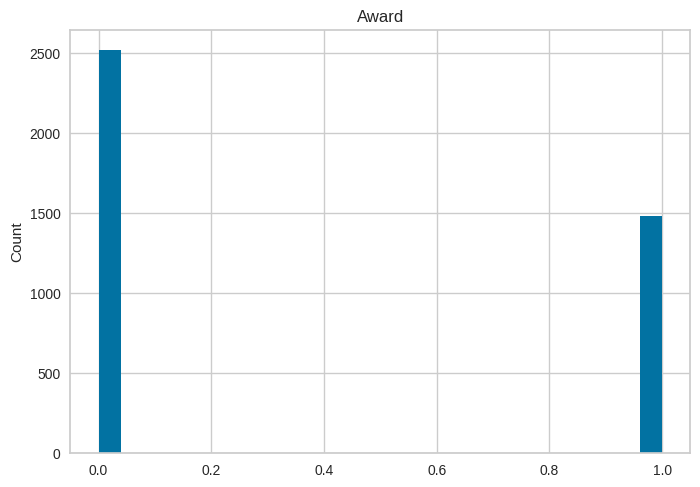

In [12]:
for feature in data.columns:
    data=data.copy()
    data[feature].hist(bins=25)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

Balance


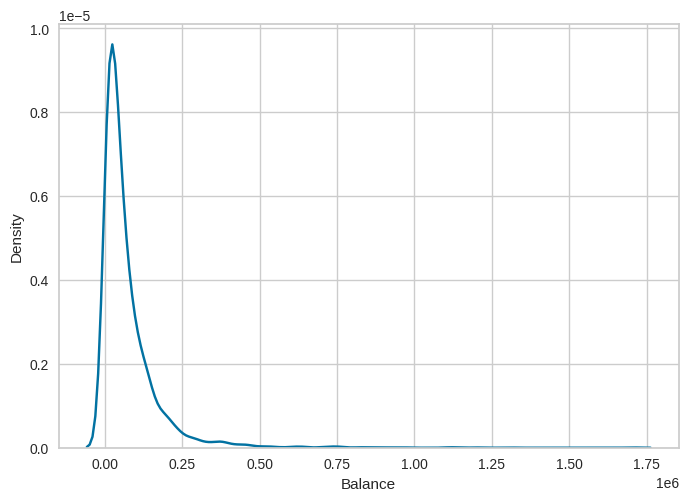

Qual_miles


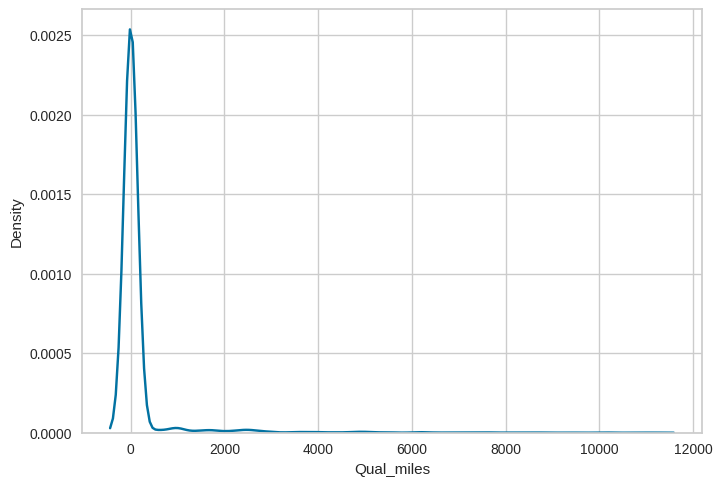

cc1_miles


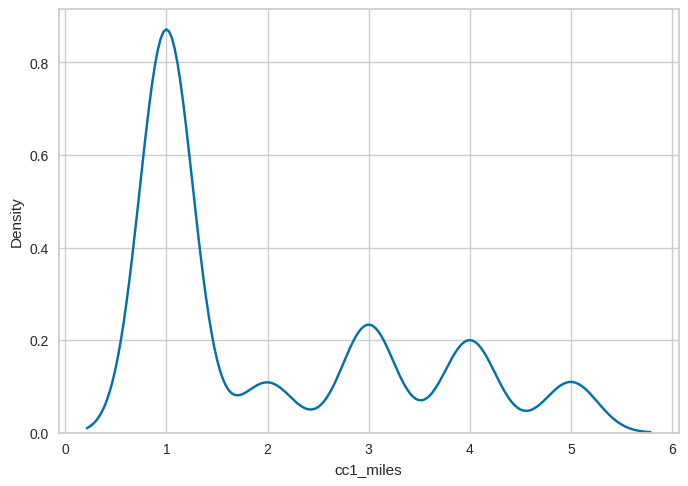

cc2_miles


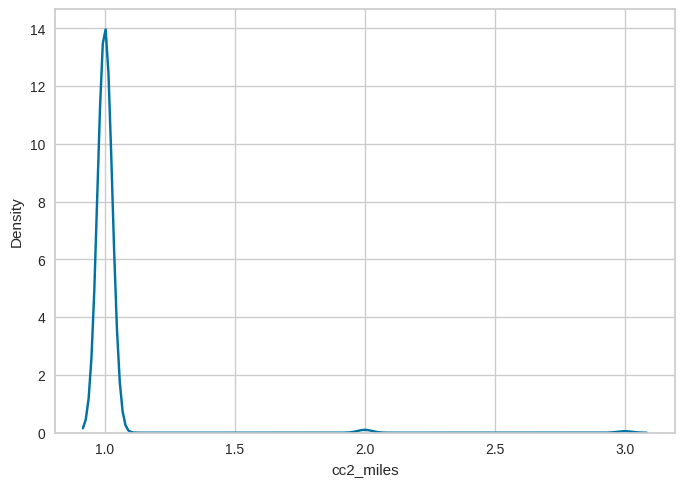

cc3_miles


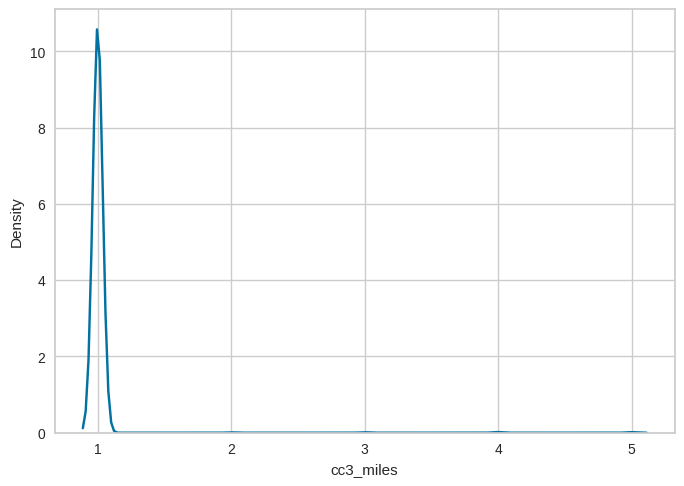

Bonus_miles


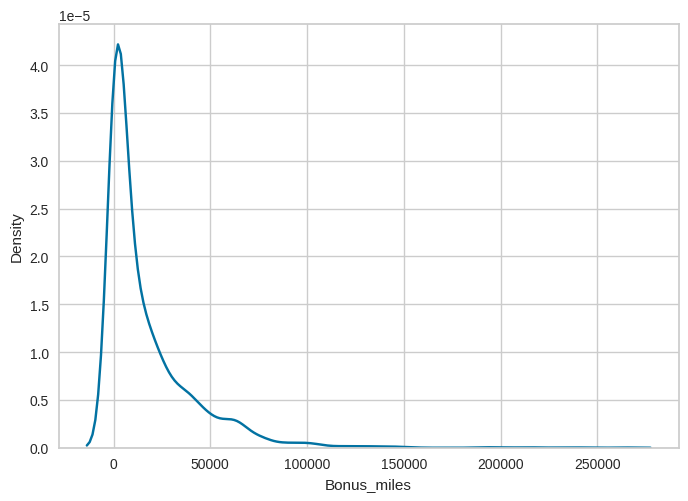

Bonus_trans


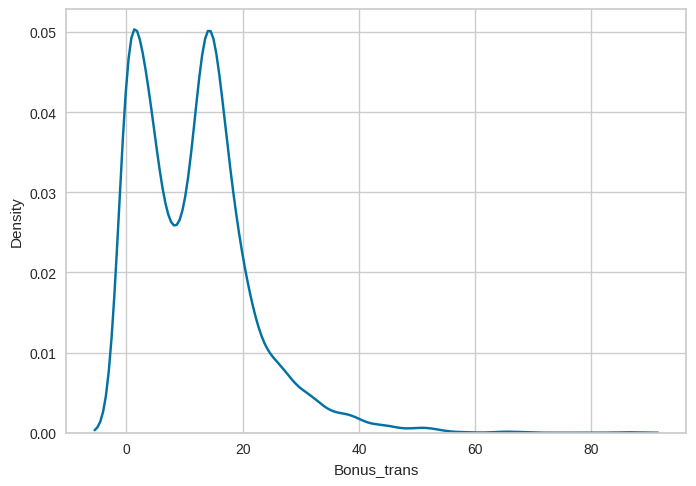

Flight_miles_12mo


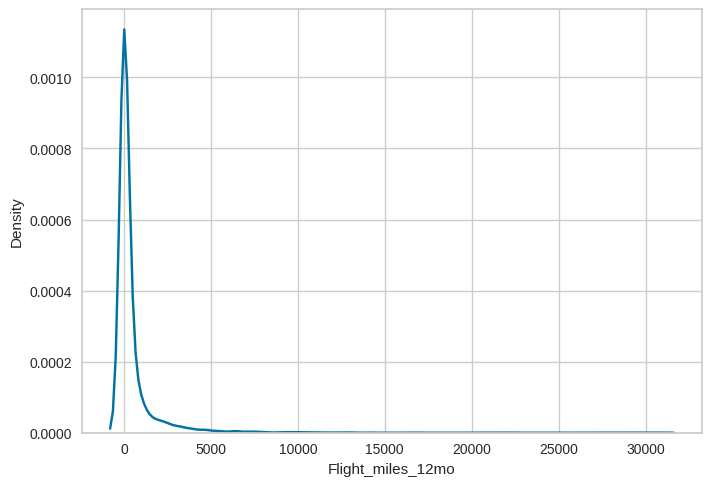

Flight_trans_12


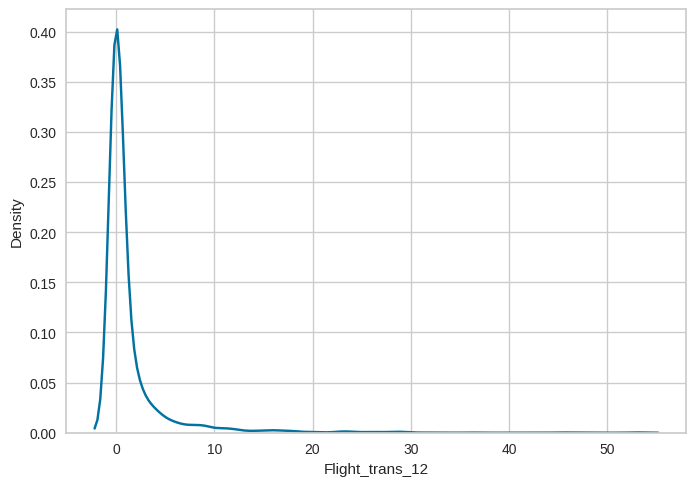

Days_since_enroll


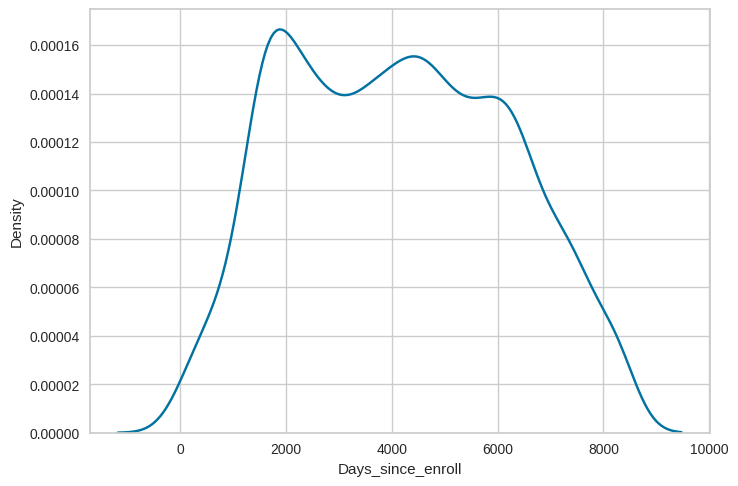

Award


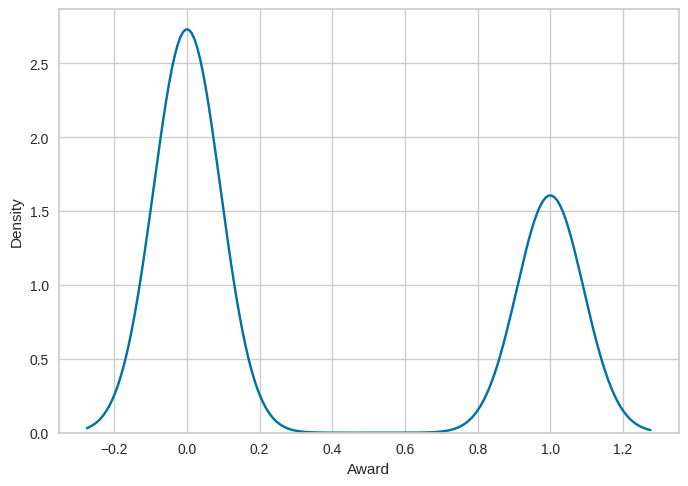

In [13]:
for n in data.columns:
    print(n)
    sns.kdeplot(data[n])
    plt.show()

# 3 Outliers Detection

In [14]:
data.columns

Index(['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award'],
      dtype='object')

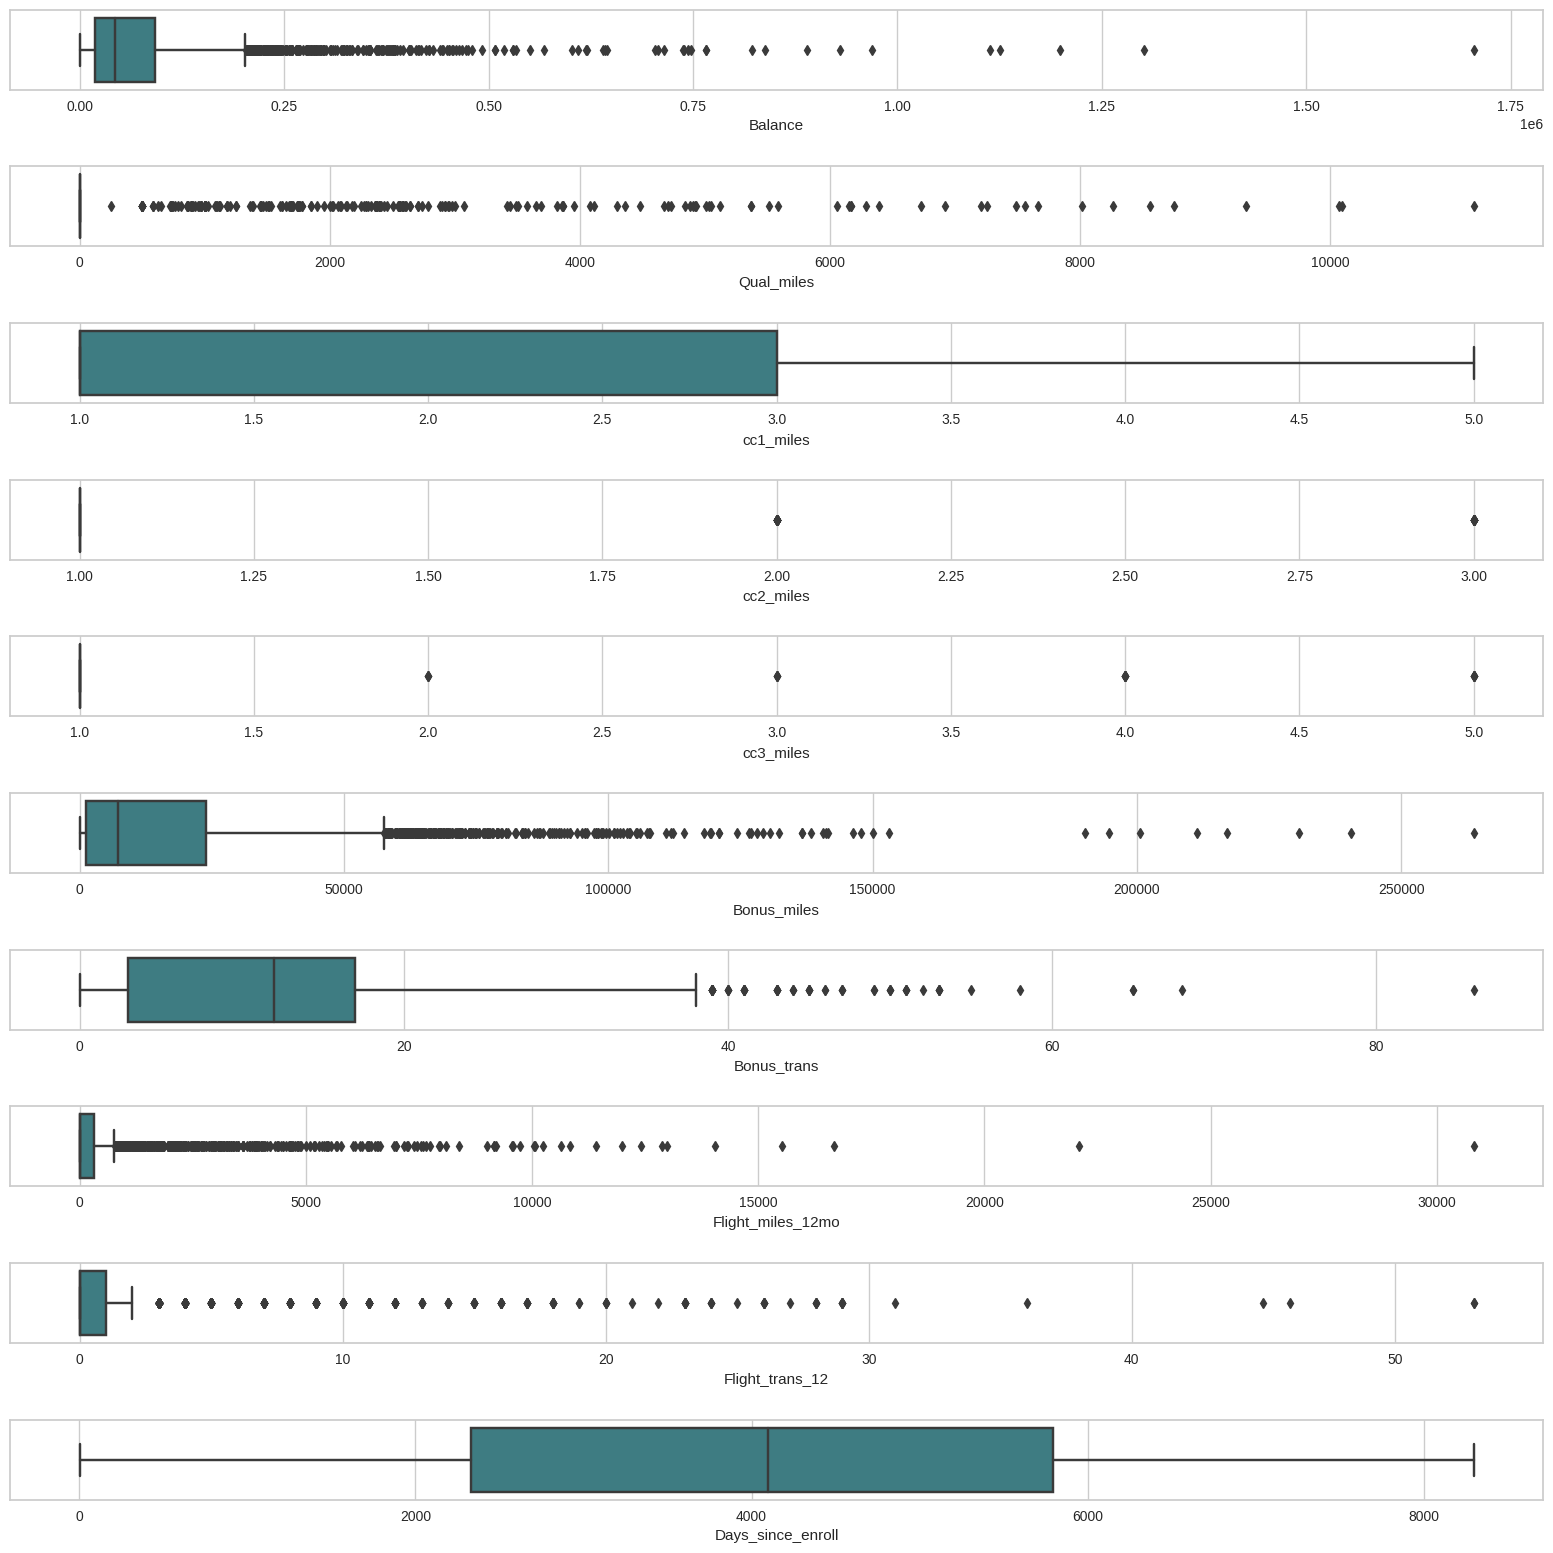

In [15]:
ot=data.copy() 
fig, axes=plt.subplots(10,1,figsize=(16,16),sharex=False,sharey=False)
sns.boxplot(x='Balance',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='Qual_miles',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='cc1_miles',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='cc2_miles',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='cc3_miles',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='Bonus_miles',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='Bonus_trans',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='Flight_miles_12mo',data=ot,palette='crest',ax=axes[7])
sns.boxplot(x='Flight_trans_12',data=ot,palette='crest',ax=axes[8])
sns.boxplot(x='Days_since_enroll',data=ot,palette='crest',ax=axes[9])
plt.tight_layout(pad=2.0)

<Axes: >

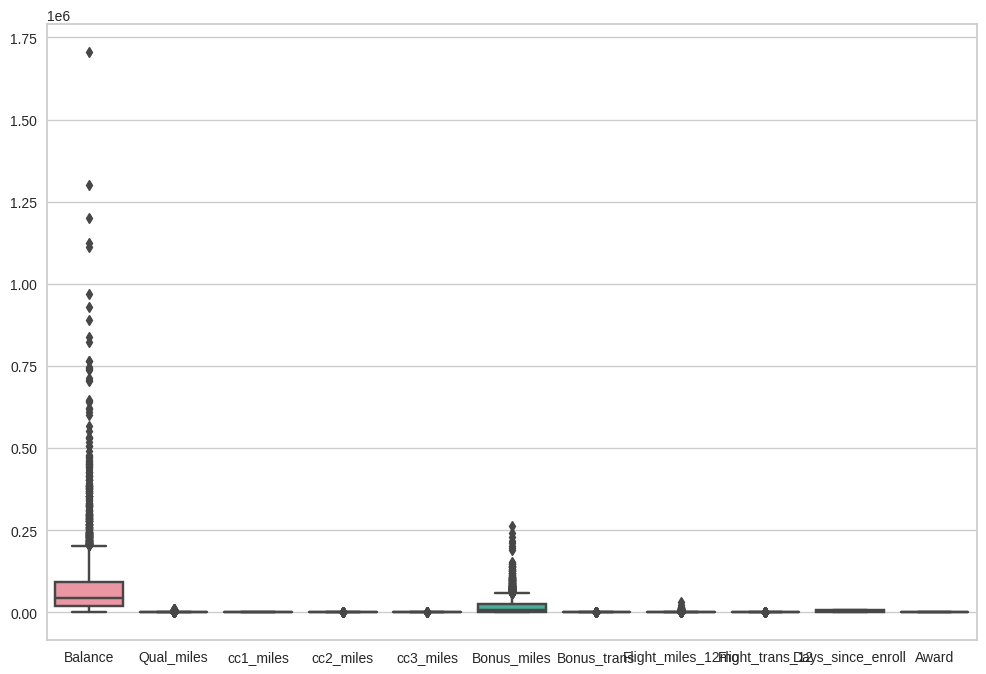

In [16]:
# Box plot for every feature in the same graph

plt.figure(figsize=(12,8))
sns.boxplot(data=data)

<Axes: >

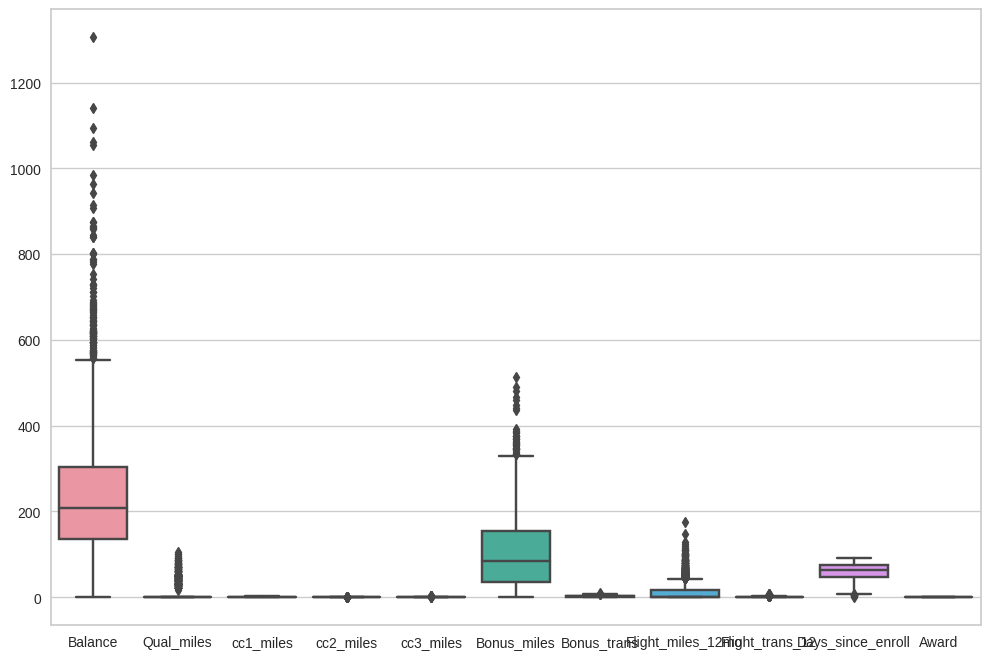

In [17]:
# we use sqrt() to see more clearly despite the outliers

plt.figure(figsize=(12,8))
sns.boxplot(data=np.sqrt(data))

# 4. Data Visualization

In [18]:
countNoAward = len(data[data.Award == 0])
counthaveAward = len(data[data.Award == 1])
print("Percentage of Customer doesn't have a Award: {:.2f}%".format((countNoAward / (len(data.Award))*100)))
print("Percentage of Customer does have a Award: {:.2f}%".format((counthaveAward / (len(data.Award))*100)))

Percentage of Customer doesn't have a Award: 62.97%
Percentage of Customer does have a Award: 37.03%


Text(0.5, 1.0, 'Whether the client has a Award or not ')

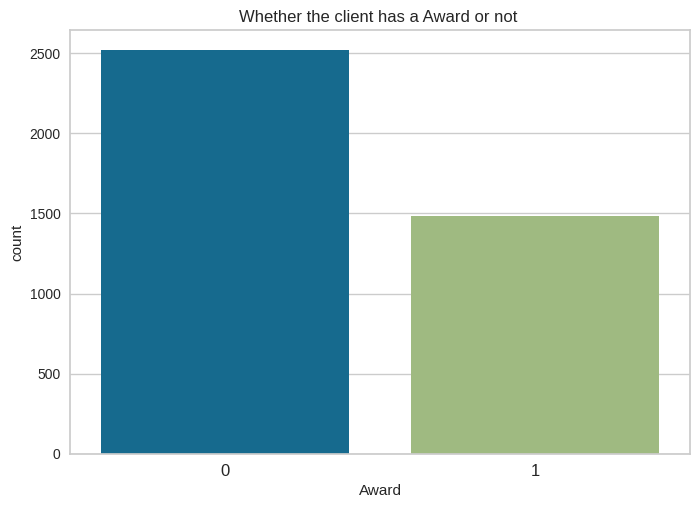

In [19]:
sns.countplot(x='Award', data=data, 
              order=data['Award'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Whether the client has a Award or not ')

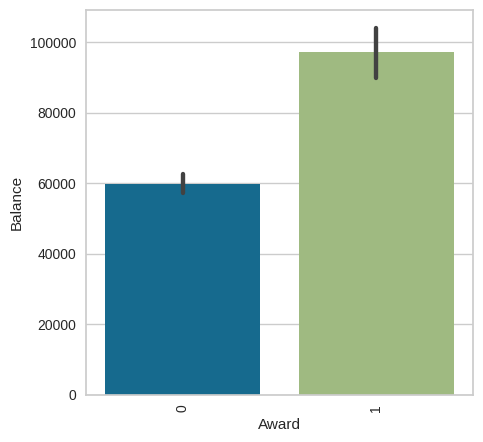

In [20]:
# Balance : Number of miles eligible for award travel

plt.figure(figsize = (5,5))
Balance = data[['Award','Balance']].sort_values('Balance', ascending = False)
ax = sns.barplot(x='Award', y='Balance', data= Balance)
ax.set(xlabel = 'Award', ylabel= 'Balance')
plt.xticks(rotation=90)
plt.show()

In [21]:
# what is correlated with Balance?

corr_matrix = data.corr()
corr_matrix["Balance"].sort_values(ascending=False)

Balance              1.000000
Bonus_miles          0.403487
cc1_miles            0.338344
Bonus_trans          0.324935
Days_since_enroll    0.263129
Flight_trans_12      0.255700
Flight_miles_12mo    0.217551
Award                0.178494
Qual_miles           0.108722
cc3_miles            0.035243
cc2_miles           -0.008804
Name: Balance, dtype: float64

In [22]:
dataset = pd.read_excel('EastWestAirlines.xlsx',sheet_name='data')
sns.pairplot(dataset)

Output hidden; open in https://colab.research.google.com to view.

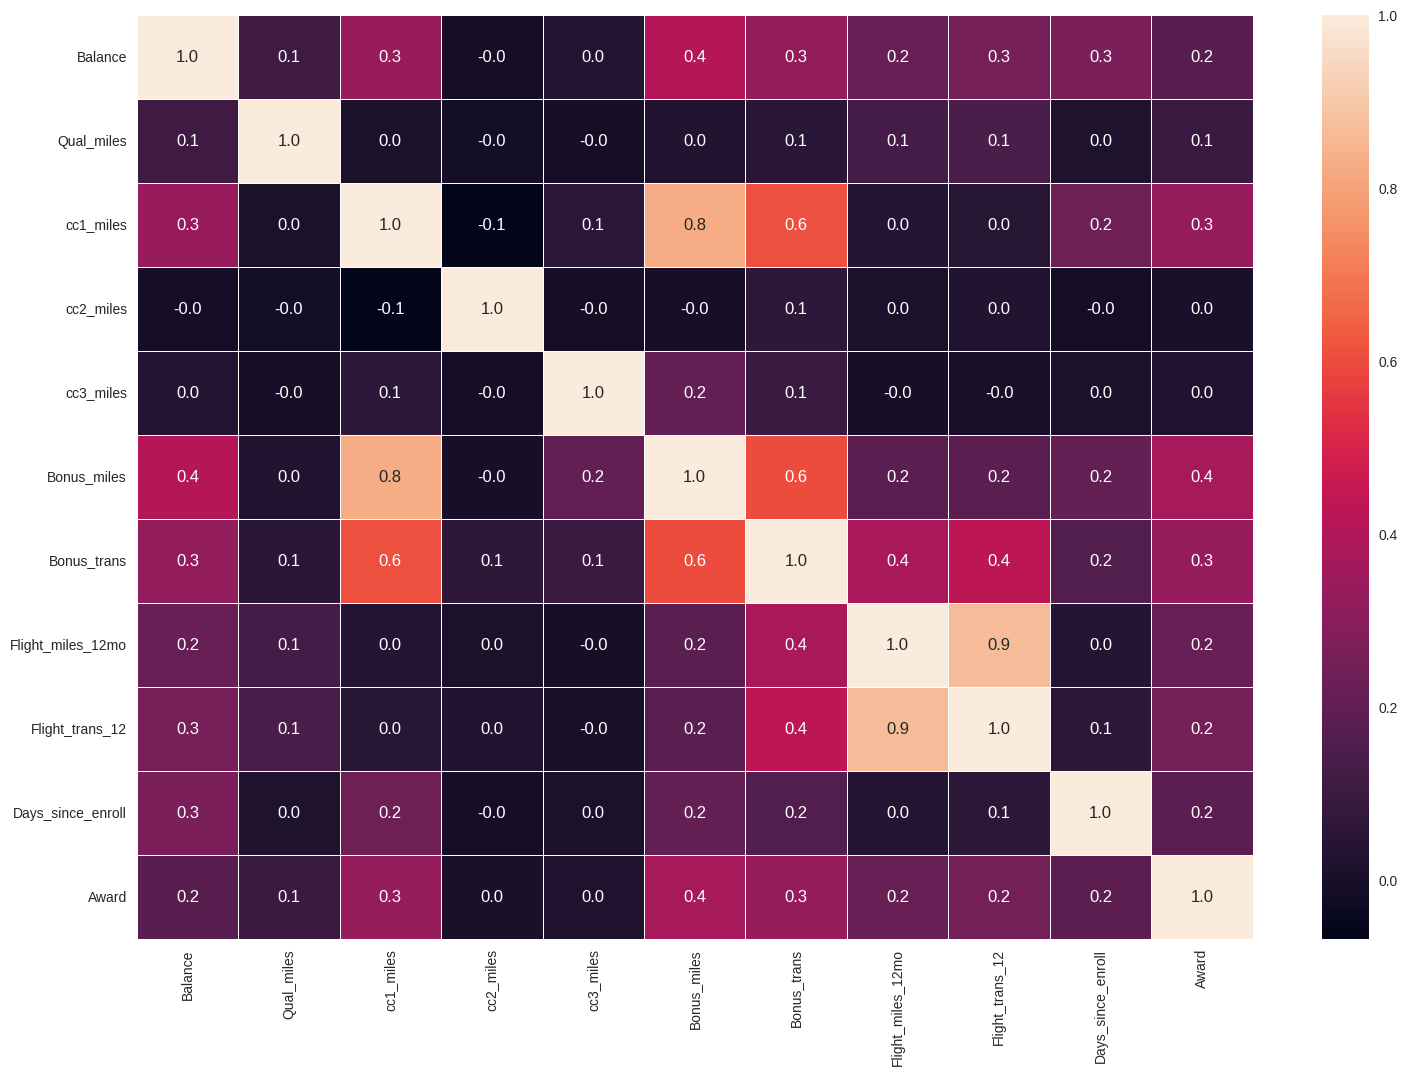

In [23]:
# correlation heatmap

f,ax = plt.subplots(figsize=(18,12))
sns.heatmap(data.corr(), annot=True, linewidths =.5, fmt ='.1f',ax=ax)
plt.show()

**Unique points in this correlation matrix**:

* flight_trans_12 is positively correlated with flight_miles_12mo
* bonus_trans is positively correlated with cc1_miles
* bonus_trans is positively correlated with bonus_miles
* bonus_miles is positively correlated with cc1_miles

In other words, the following are positively correlated

* Number of flight transactions in the past 12 months <-> Number of flight miles in the past 12 months
* Miles passengers earn with the freq. flyer credit card <-> Amount of non-flight transactions
* Number of non-flight bonus transactions <-> Miles passengers earn from non-flight bonus transactions
* Miles passengers earn from non-flight bonus transactions <-> Miles passengers earn with the freq. flyer credit card 

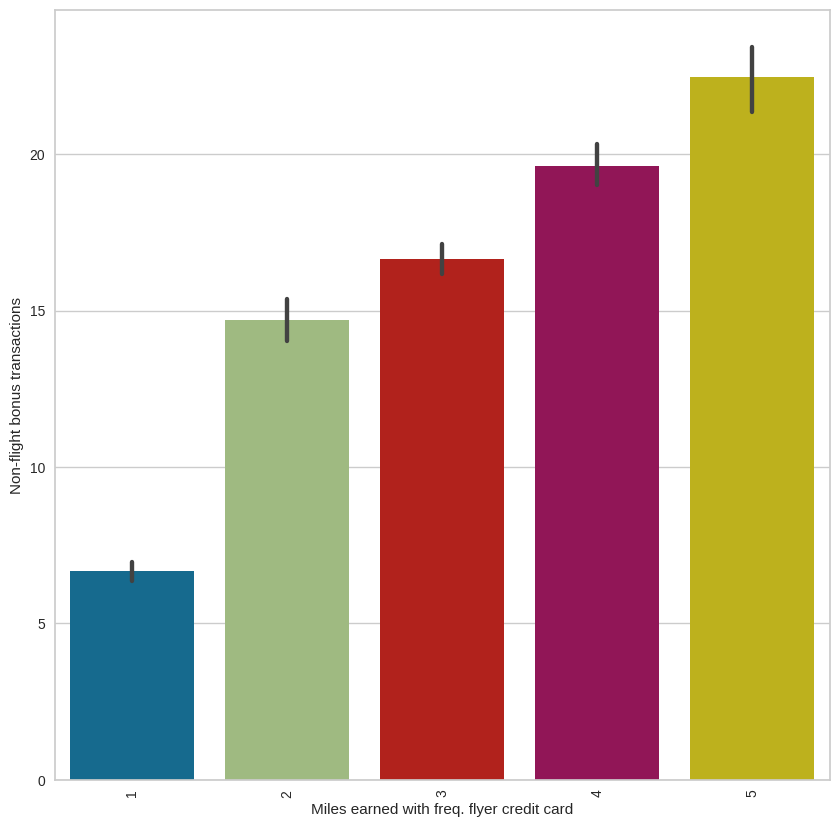

In [24]:
# Plotting frequent flying bonuses vs. non-flight bonus transactions 
plt.figure(figsize = (10,10))
sorted_data = data[['cc1_miles','Bonus_trans']].sort_values('Bonus_trans', ascending = False)
ax = sns.barplot(x='cc1_miles', y='Bonus_trans', data= sorted_data)
ax.set(xlabel = 'Miles earned with freq. flyer credit card', ylabel= 'Non-flight bonus transactions')
plt.xticks(rotation=90)
plt.show()

# 5. Data Preprocessing
**5.1) Standardizing the Data**

In [25]:
standard_scaler = StandardScaler()
std_df = standard_scaler.fit_transform(data)
std_df.shape

(3999, 11)

**5.2) Normalizing the data**

In [26]:
# Using Minmaxscaler for accuracy result comparison

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

minmax_df = minmax.fit_transform(data)
minmax_df.shape

(3999, 11)

# 6. KMeans Clustering

After all the analyses we now start with the K-Means Clustering procedure

K-means is a centroid-based algorithm, or a distance-based algorithm, where we calculate the distances to assign a point to a cluster. In K-Means, each cluster is associated with a centroid.

The main objective of the K-Means algorithm is to minimize the sum of distances between the points and their respective cluster centroid. The first step in k-means is to pick the number of clusters, k. Then keep the iterations running until one of the below satisifes:

* Centroids of newly formed clusters do not change
* Points remain in the same cluster
* Maximum number of iterations are reached
In K Means clustering we need to first assign the K number of clusters which can be taken up plotting the Elbow curve.

**6.1 Elbow Method for Determining Cluster Amount**

Standard Scaler Applied on Data

In [27]:
cluster_range = range(1,15)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters,n_init=10)
    clusters.fit(std_df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)
clusters_df = pd.DataFrame({"num_clusters":cluster_range,"cluster_errors":cluster_errors})
clusters_df

,num_clusters,cluster_errors
0,1,43989.000000
1,2,35409.516630
2,3,30899.271222
3,4,27153.948187
4,5,23706.733816
5,6,21756.926621
6,7,18893.629987
7,8,17371.973213
8,9,16050.782490
9,10,14728.300181


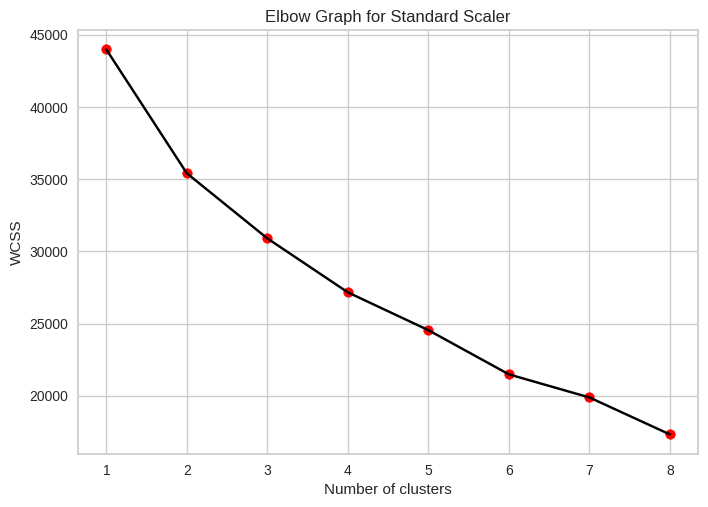

In [28]:
# within-cluster sum-of-squares criterion 
# Use Elbow Graph to find optimum number of  clusters (K value) from K values range
# The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion WCSS 
# random state can be anything from 0 to 42, but the same number to be used everytime,so that the results don't change. 

wcss=[]
for i in range(1,9):
    kmeans=KMeans(n_clusters=i,random_state=2)
    kmeans.fit(std_df)
    wcss.append(kmeans.inertia_)
    
# Plot K values range vs WCSS to get Elbow graph for choosing K (no. of clusters)
plt.plot(range(1,9),wcss,color = 'black')
plt.scatter(range(1,9),wcss,color='red')
plt.title('Elbow Graph for Standard Scaler')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

There is no clear "elbow" visible. A choice of 3 or 4 clusters seems to be fair. Let's see the silhouette score

# 6.2 Silhouette Score

In [29]:
from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(std_df)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(std_df, KM_est.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

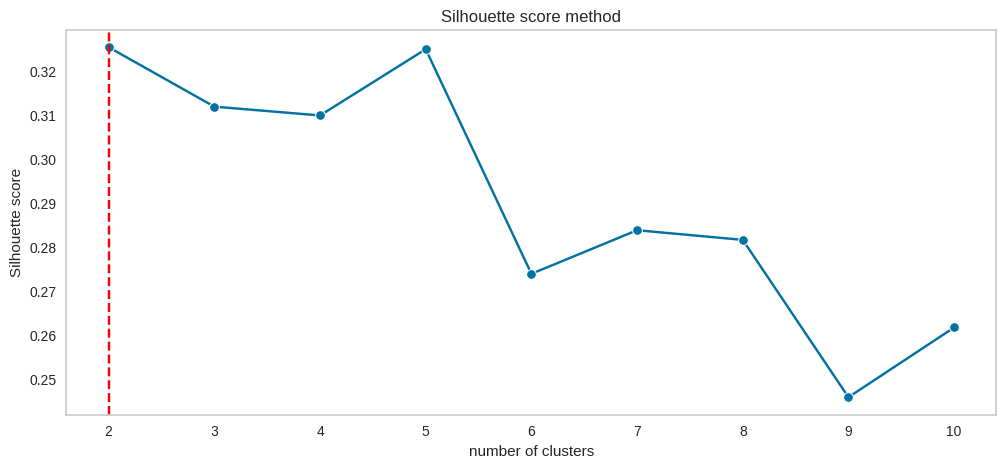

In [30]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(x=n_clusters, y=s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")

#fig, ax = plt.subplots(figsize=(12,5))
#ax = sns.lineplot(n_clusters, s_scores, marker='o', ax=ax)
#ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(2, ls="--", c="red")
plt.grid()
plt.show()

Silhouette score method indicates the best options would be respectively 2 clusters.

Elbow Plot for Standard Scaler data


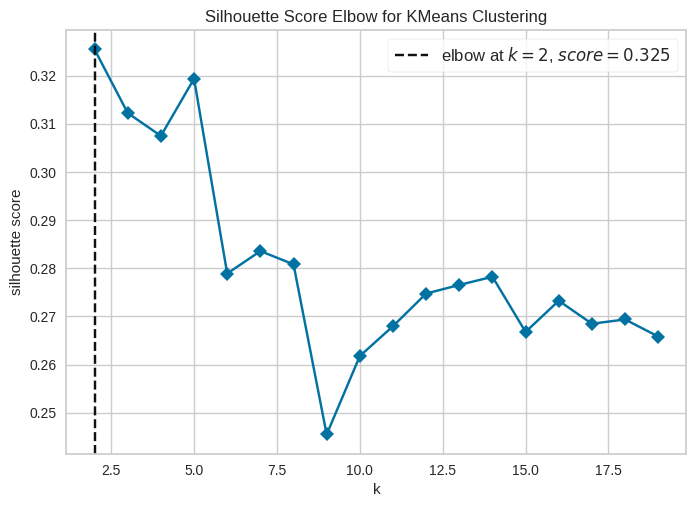

In [31]:
# 1. How many number of clusters? n_clusters?

# Since true labels are not known..we will use Silhouette Coefficient (Clustering performance evaluation)
# knee Elbow graph method


# Instantiate a scikit-learn K-Means model. we will check for two diff hyperparameters value effect.
model = KMeans(random_state=10, max_iter=500, init='k-means++')

# Instantiate the KElbowVisualizer with the number of clusters and the metric
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False)
# Fit the data and visualize
print('Elbow Plot for Standard Scaler data')
visualizer.fit(std_df)    
visualizer.poof()
plt.show()

In [32]:
# With the elbow method, the ideal number of clusters to use was 6.
# We will also use the Silhouette score to determine an optimal number.

clust_list = [2,3,4,5,6,7,8,9]

#  Silhouette score for stadardScaler applied on data.

for n_clusters in clust_list:
    clusterer1 = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels1 = clusterer1.fit_predict(std_df)
    sil_score1= sil(std_df, cluster_labels1)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", sil_score1)

For n_clusters = 2 The average silhouette_score is : 0.3256981835090824
For n_clusters = 3 The average silhouette_score is : 0.3121716765282414
For n_clusters = 4 The average silhouette_score is : 0.32563311512799126
For n_clusters = 5 The average silhouette_score is : 0.31819537664378844
For n_clusters = 6 The average silhouette_score is : 0.3338735662323181
For n_clusters = 7 The average silhouette_score is : 0.22085896619040385
For n_clusters = 8 The average silhouette_score is : 0.23657639934232003
For n_clusters = 9 The average silhouette_score is : 0.2984364654012059


In [33]:
range_n_clusters = [2,3,4,5,6,7,8,9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(std_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(std_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sil(std_df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(std_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(std_df[:,6], std_df[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:,6], centers[:,9], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[6], c[9], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data after Standard scaler.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**
According the the silhouette score of:

The standardized data, the ideal number of clusters is 6, with a score higher than other options, of 0.33

# 6.3 Build KMeans Cluster algorithm using K=6 and Standard Scaler Applied Dataset


In [34]:
# we have found good number of cluster = 6
# model building using cluster numbers = 6

model_kmeans = KMeans(n_clusters=6, random_state=0, init='k-means++')
y_predict_kmeans = model_kmeans.fit_predict(std_df)
y_predict_kmeans.shape

(3999,)

In [35]:
# these are nothing but cluster labels...

y_predict_kmeans

array([2, 2, 2, ..., 1, 2, 2], dtype=int32)

In [36]:
model_kmeans.labels_

array([2, 2, 2, ..., 1, 2, 2], dtype=int32)

In [37]:
# cluster centres associated with each lables

model_kmeans.cluster_centers_

array([[ 1.13686833,  0.4142613 ,  0.1345493 , -0.09824189, -0.06276658,
         0.65640088,  1.70548646,  3.77107713,  4.00212558,  0.27153799,
         0.88395812],
       [ 0.43381284, -0.11301262,  1.21014978, -0.09824189, -0.05449778,
         0.92813517,  0.75269133, -0.08065818, -0.08956555,  0.37079373,
         0.57854007],
       [-0.29444721, -0.12883455, -0.60151188, -0.09824189, -0.06071593,
        -0.51682757, -0.4934919 , -0.18636264, -0.19845942, -0.19791068,
        -0.34993321],
       [-0.04688966, -0.1562356 , -0.66822727,  9.03825361, -0.06276658,
        -0.10166533,  0.61785114,  0.0875494 ,  0.22034681, -0.07246398,
         0.05178388],
       [ 0.63971926, -0.08443292,  1.0220844 , -0.09824189, 15.64629931,
         3.17969131,  1.71461374,  0.03329269,  0.05969539,  0.23987261,
         0.33752735],
       [ 0.45710365,  6.73109194, -0.04322862, -0.09824189, -0.06276658,
         0.06371677,  0.06535804,  0.3596938 ,  0.39424679, -0.07122344,
         0.387

In [38]:
# within-cluster sum of squared

# The lower values of inertia are better and zero is optimal.
# Inertia is the sum of squared error for each cluster. 
# Therefore the smaller the inertia the denser the cluster(closer together all the points are)

model_kmeans.inertia_

21089.973628929638

In [39]:
#Assign clusters to the data set
df = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data')
#df.drop_duplicates(inplace=True)
#df.duplicated().sum()
#df[df.duplicated()]
df.rename({'ID#':'ID', 'Award?':'Award'}, inplace=True, axis=1)
df['Kmeans_label'] = model_kmeans.labels_

In [40]:
# Group data by Clusters (K=6)
df.groupby('Kmeans_label').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Kmeans_label,,,,,,,,,,,,
0,1743.867133,188155.664336,464.573427,2.244755,1.000000,1.000000,32995.580420,27.979021,5739.692308,16.552448,4679.251748,0.797203
1,1599.831858,117176.916331,58.446500,3.720837,1.000000,1.001609,39485.872084,18.811746,346.617860,1.032180,4887.485921,0.649236
2,2233.860465,43882.372895,43.558140,1.229751,1.000000,1.000401,4644.210104,6.852847,199.160385,0.621091,3706.378508,0.200882
3,2269.372093,68876.581395,23.255814,1.139535,2.348837,1.000000,14689.837209,17.534884,582.627907,2.209302,3968.930233,0.395349
4,1664.866667,138061.400000,78.800000,3.466667,1.000000,4.066667,93927.866667,28.066667,506.666667,1.600000,4613.866667,0.533333
5,2057.295082,119660.491803,5351.065574,2.000000,1.000000,1.000000,18683.475410,12.229508,963.639344,2.868852,3971.491803,0.557377


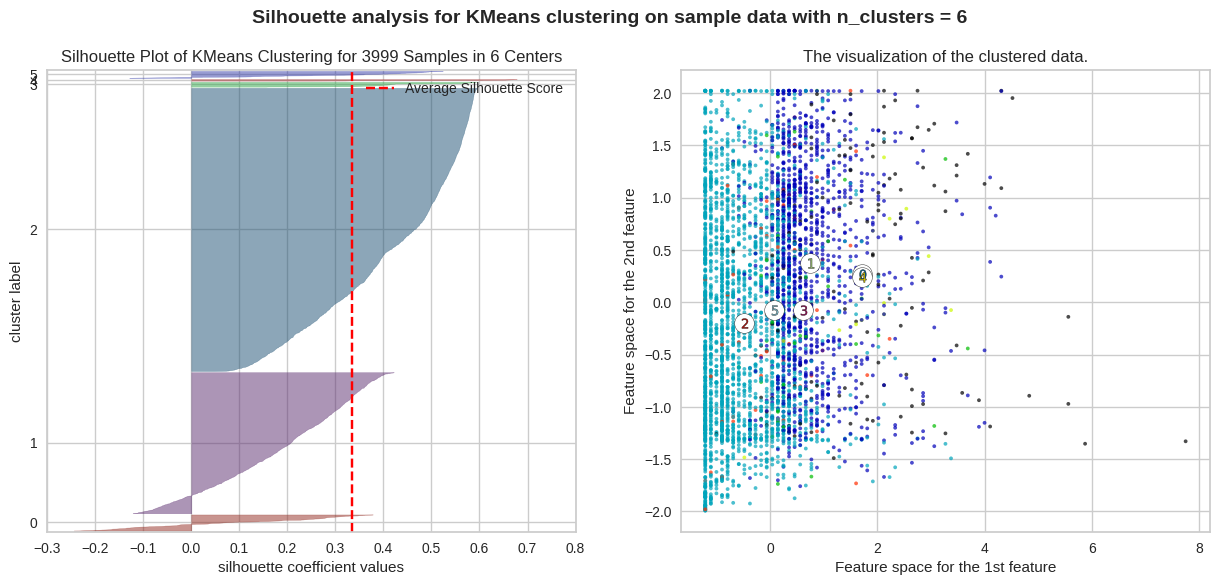

In [41]:
from yellowbrick.cluster import SilhouetteVisualizer

fig,(ax1,ax2) = plt.subplots(1,2,sharey=False)
fig.set_size_inches(15,6)



sil_visualizer1 = SilhouetteVisualizer(model_kmeans,ax= ax1, colors=['#922B21','#5B2C6F','#1B4F72','#32a84a','#a83232','#323aa8'])
sil_visualizer1.fit(std_df)


# 2nd Plot showing the actual clusters formed

import matplotlib.cm as cm
colors1 = cm.nipy_spectral(model_kmeans.labels_.astype(float) / 6) # 6 is number of clusters
ax2.scatter(std_df[:, 6], std_df[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                c=colors1, edgecolor='k')

# Labeling the clusters
centers1 = model_kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers1[:, 6], centers1[:, 9], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers1):
    ax2.scatter(c[6], c[9], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')


ax2.set_title(label ="The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % 6),fontsize=14, fontweight='bold')

sil_visualizer1.show()
plt.show()

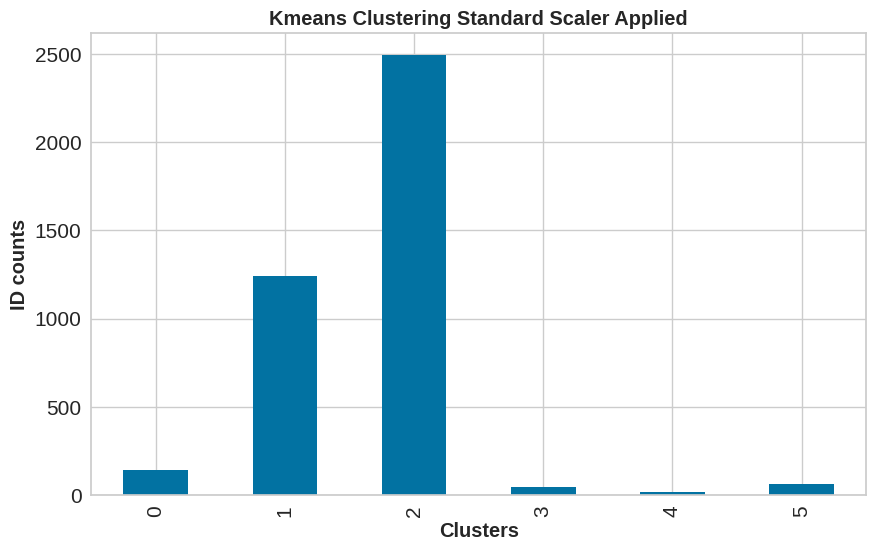

In [42]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Kmeans_label']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Kmeans Clustering Standard Scaler Applied',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# 6.4 Elbow Method and Silhouette Score on MinMaxScaler Applied Data

In [43]:
cluster_range = range(1,15)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters,n_init=10)
    clusters.fit(minmax_df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)
clusters_df = pd.DataFrame({"num_clusters":cluster_range,"cluster_errors":cluster_errors})
clusters_df

,num_clusters,cluster_errors
0,1,1830.793213
1,2,823.675698
2,3,625.176821
3,4,436.709682
4,5,348.943322
5,6,315.151064
6,7,287.730762
7,8,263.193520
8,9,243.930513
9,10,226.117432


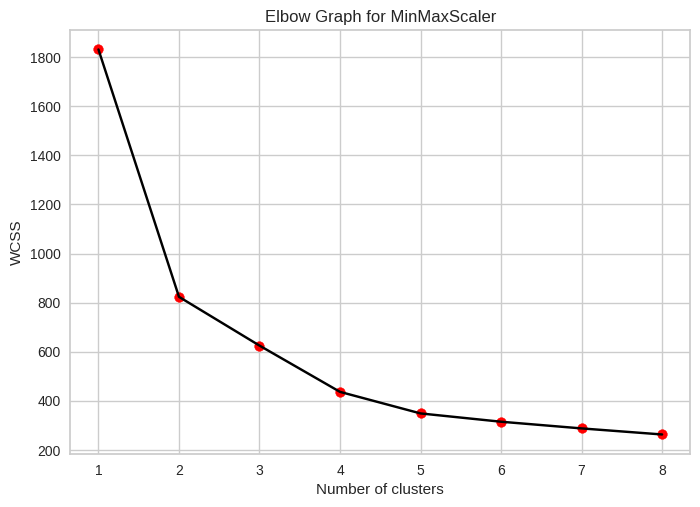

In [44]:
wcss=[]
for i in range (1,9):
    kmeans=KMeans(n_clusters=i,random_state=2)
    kmeans.fit(minmax_df)
    wcss.append(kmeans.inertia_)
    
# Plot K values range vs WCSS to get Elbow graph for choosing K (no. of clusters)
plt.plot(range(1,9),wcss,color = 'black')
plt.scatter(range(1,9),wcss,color='red')
plt.title('Elbow Graph for MinMaxScaler')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

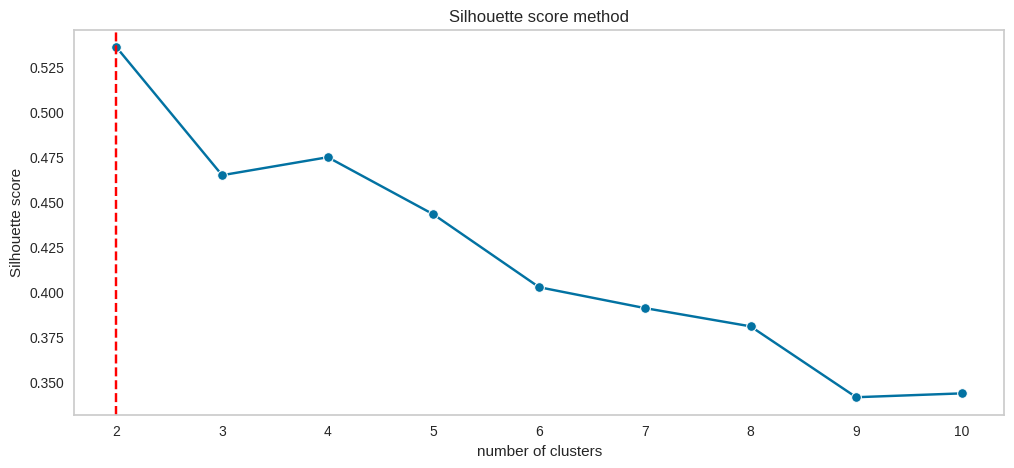

In [45]:
from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(minmax_df)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(minmax_df, KM_est.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(x=n_clusters, y=s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")



#fig, ax = plt.subplots(figsize=(12,5))
#ax = sns.lineplot(n_clusters, s_scores, marker='o', ax=ax)
#ax.set_title("Silhouette score method")

ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(2, ls="--", c="red")
plt.grid()
plt.show()

Elbow Plot for MinMaxScaler data


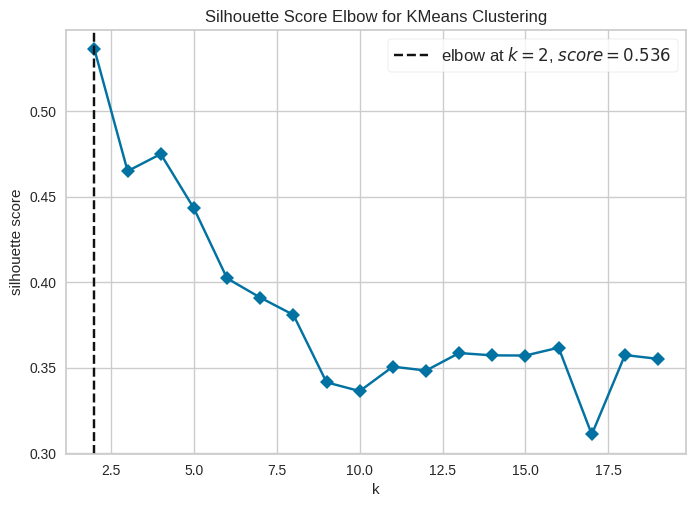

In [46]:
# Instantiate a scikit-learn K-Means model. we will check for two diff hyperparameters value effect.
model = KMeans(random_state=10, max_iter=500, init='k-means++')

# Instantiate the KElbowVisualizer with the number of clusters and the metric
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False)
# Fit the data and visualize
print('Elbow Plot for MinMaxScaler data')
visualizer.fit(minmax_df)    
visualizer.poof()
plt.show()

In [47]:
# With the elbow method, the ideal number of clusters to use was 6.
# We will also use the Silhouette score to determine an optimal number.

clust_list = [2,3,4,5,6,7,8,9]

#  Silhouette score for MinMaxScaler Applied on data .

for n_clusters in clust_list:
    clusterer1 = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels1 = clusterer1.fit_predict(minmax_df)
    sil_score1= sil(minmax_df, cluster_labels1)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", sil_score1)

For n_clusters = 2 The average silhouette_score is : 0.535930510919477
For n_clusters = 3 The average silhouette_score is : 0.46484529388583046
For n_clusters = 4 The average silhouette_score is : 0.4744941579482721
For n_clusters = 5 The average silhouette_score is : 0.4430672072796034
For n_clusters = 6 The average silhouette_score is : 0.38865859989228385
For n_clusters = 7 The average silhouette_score is : 0.3909601011818369
For n_clusters = 8 The average silhouette_score is : 0.38030165896247936
For n_clusters = 9 The average silhouette_score is : 0.3842538055607832


In [48]:
range_n_clusters = [2,3,4,5,6,7,8,9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(minmax_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(minmax_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sil(minmax_df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(minmax_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(minmax_df[:,6], minmax_df[:,9], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:,6], centers[:,9], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[6], c[9], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data after Standard scaler.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**
According the the silhouette score of:

* The MinMax Scaler Applied data, the ideal number of clusters is 2, with a score higher than other options, of 0.53, but if you notice the number of cluster 5 has also the best variation within cluster and between cluster with zero to no values going towards -1 and no mismatch in cluster segregation than the consecutive rest

* If we check silhouette score with Normalize data kmeans model 0.53>0.32. Best score always close to +1.

# 6.5 Build KMeans Cluster algorithm using K=2 and MinMaxScaler Applied Dataset

In [49]:
# we have found good number of cluster = 2
# model building using cluster numbers = 2

model_kmeans = KMeans(n_clusters=2, random_state=0, init='k-means++')
y_predict_kmeans = model_kmeans.fit_predict(minmax_df)
y_predict_kmeans.shape

(3999,)

In [50]:
# these are nothing but cluster labels...

y_predict_kmeans

array([1, 1, 1, ..., 0, 1, 1], dtype=int32)

In [51]:
model_kmeans.labels_

array([1, 1, 1, ..., 0, 1, 1], dtype=int32)

In [52]:
# cluster centres associated with each lables

model_kmeans.cluster_centers_

array([[ 5.69280197e-02,  2.15461508e-02,  4.15428764e-01,
         7.76502363e-03,  4.55773126e-03,  1.09621005e-01,
         1.83518364e-01,  2.78255837e-02,  4.90489598e-02,
         5.57398375e-01,  1.00000000e+00],
       [ 3.50812450e-02,  7.85813260e-03,  1.76330421e-01,
         6.94996029e-03,  2.18427323e-03,  3.87875269e-02,
         1.06313612e-01,  7.34309944e-03,  1.23113582e-02,
         4.60411394e-01, -3.05311332e-15]])

In [53]:
# within-cluster sum of squared

# The lower values of inertia are better and zero is optimal.
# Inertia is the sum of squared error for each cluster. 
# Therefore the smaller the inertia the denser the cluster(closer together all the points are)

model_kmeans.inertia_

823.6756984125209

In [54]:
#Assign clusters to the data set
df = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data')
df.rename({'ID#':'ID', 'Award?':'Award'}, inplace=True, axis=1)
df['Kmeans_label'] = model_kmeans.labels_

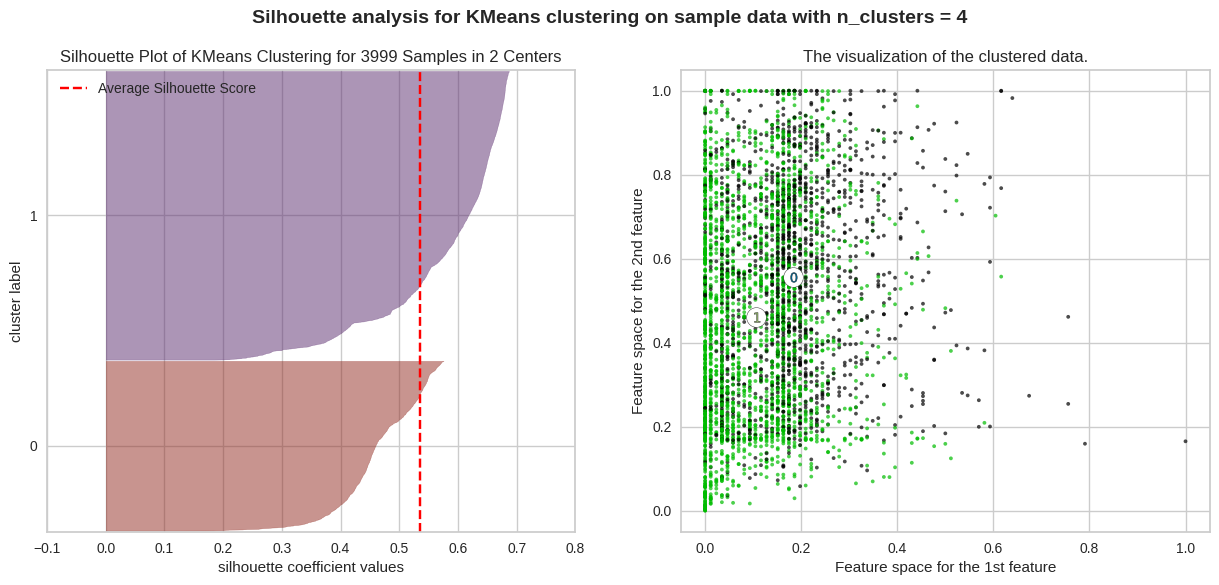

In [55]:
from yellowbrick.cluster import SilhouetteVisualizer

fig,(ax1,ax2) = plt.subplots(1,2,sharey=False)
fig.set_size_inches(15,6)



sil_visualizer1 = SilhouetteVisualizer(model_kmeans,ax= ax1, colors=['#922B21','#5B2C6F','#1B4F72','#32a84a'])
sil_visualizer1.fit(minmax_df)


# 2nd Plot showing the actual clusters formed

import matplotlib.cm as cm
colors1 = cm.nipy_spectral(model_kmeans.labels_.astype(float) / 2) # 2 is number of clusters
ax2.scatter(minmax_df[:, 6], minmax_df[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                c=colors1, edgecolor='k')

# Labeling the clusters
centers1 = model_kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers1[:, 6], centers1[:, 9], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers1):
    ax2.scatter(c[6], c[9], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')


ax2.set_title(label ="The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % 4),fontsize=14, fontweight='bold')

sil_visualizer1.show()
plt.show()

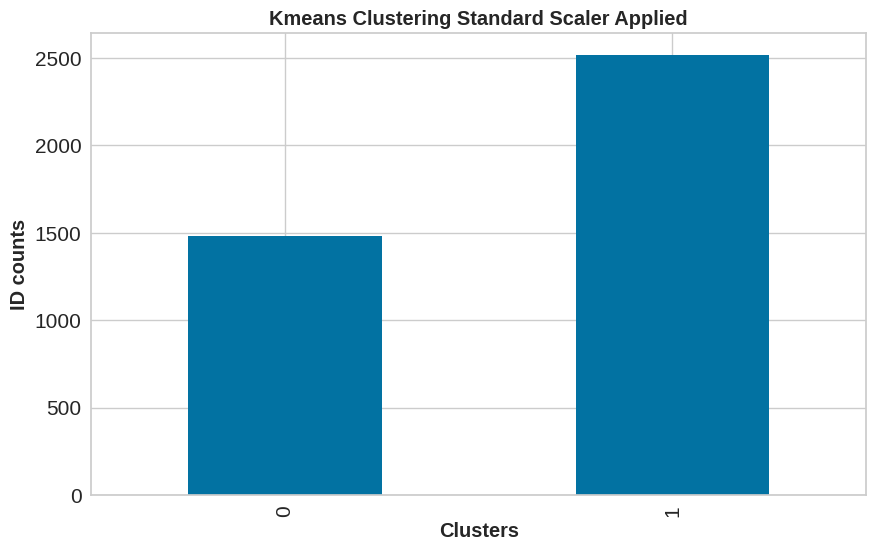

In [56]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Kmeans_label']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Kmeans Clustering Standard Scaler Applied',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [57]:
# Group data by Clusters (K=2)
df.groupby('Kmeans_label').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Kmeans_label,,,,,,,,,,,,
0,1745.592843,97053.051317,240.196489,2.661715,1.01553,1.018231,28905.414585,15.782579,857.501013,2.599595,4625.062120,1.0
1,2173.169182,59807.839555,87.602462,1.705322,1.01390,1.008737,10227.689039,9.142971,226.292295,0.652502,3820.652105,0.0


We can now clearly see the 2 number of clusters formed, which can be described as under
* Cluster1, Tier 1 = "1" = Defines the group of fliers that earn the most out of the card and are frequent fliers
* Cluster0, Tier 2 = "0" = Defines the group of fliers that earn the least and are the least frequent fliers

# 7 Hierarchical Clustering Algorithm

**7.1 Dendogram on MinMaxScaler Applied on Dataset**

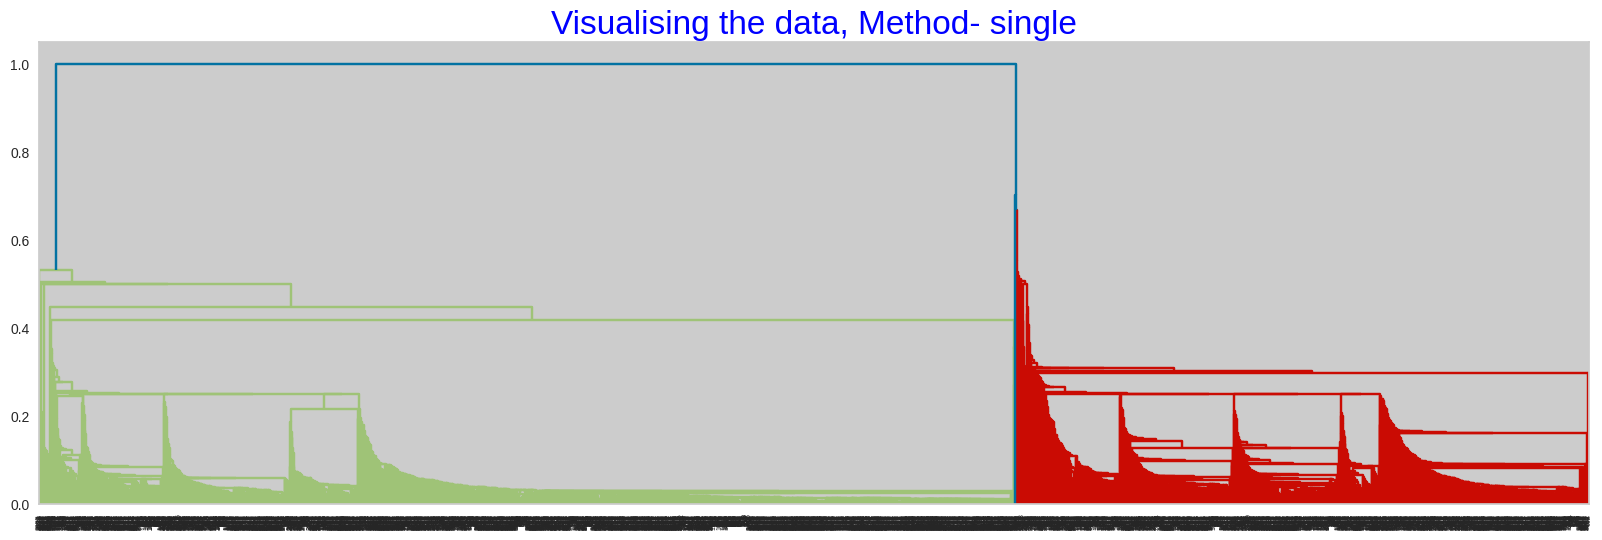

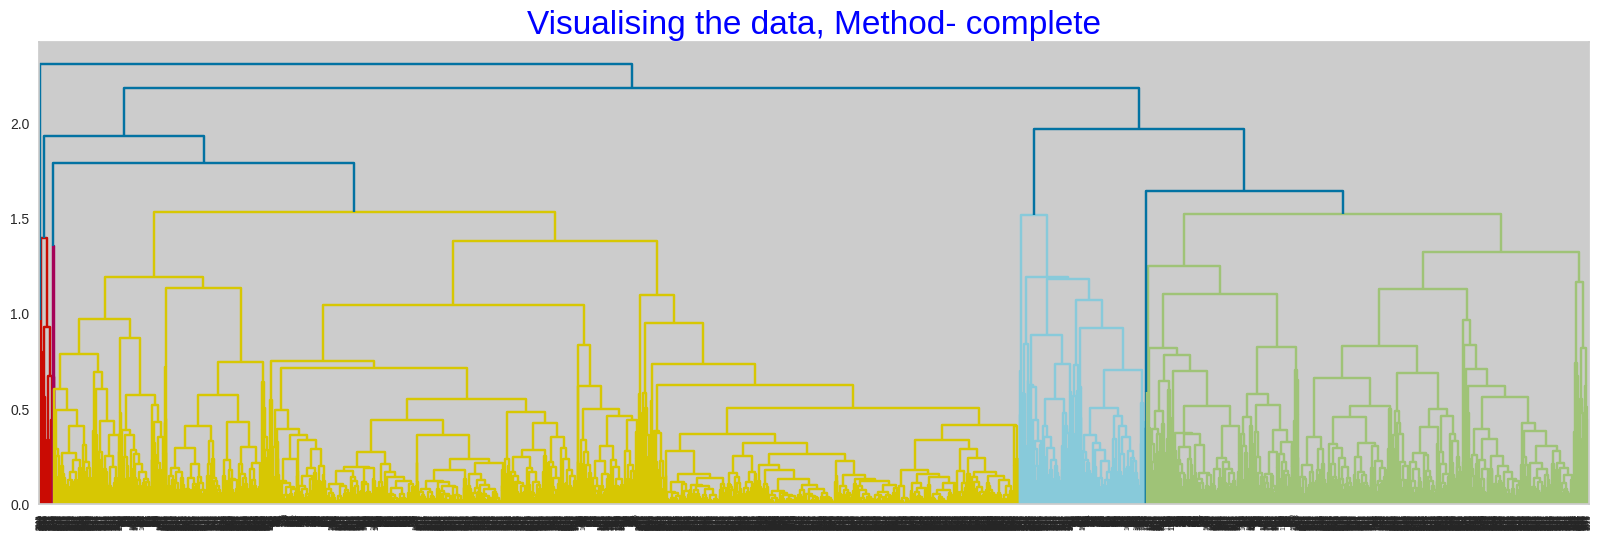

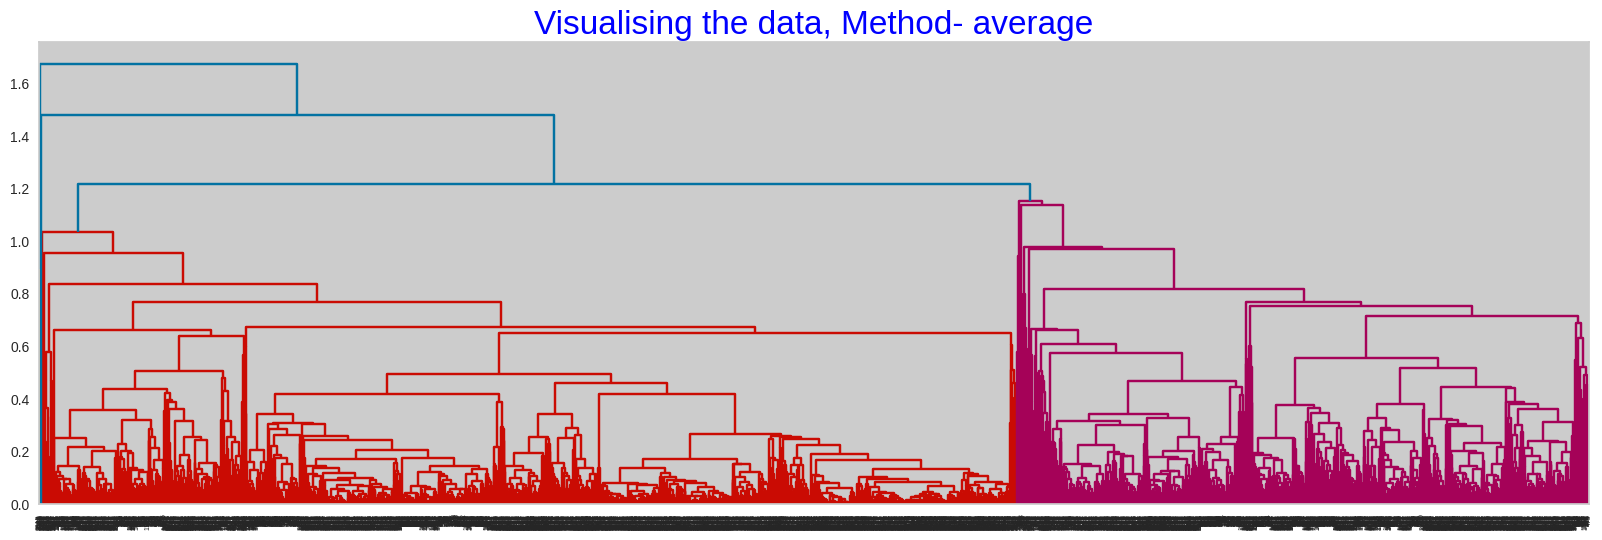

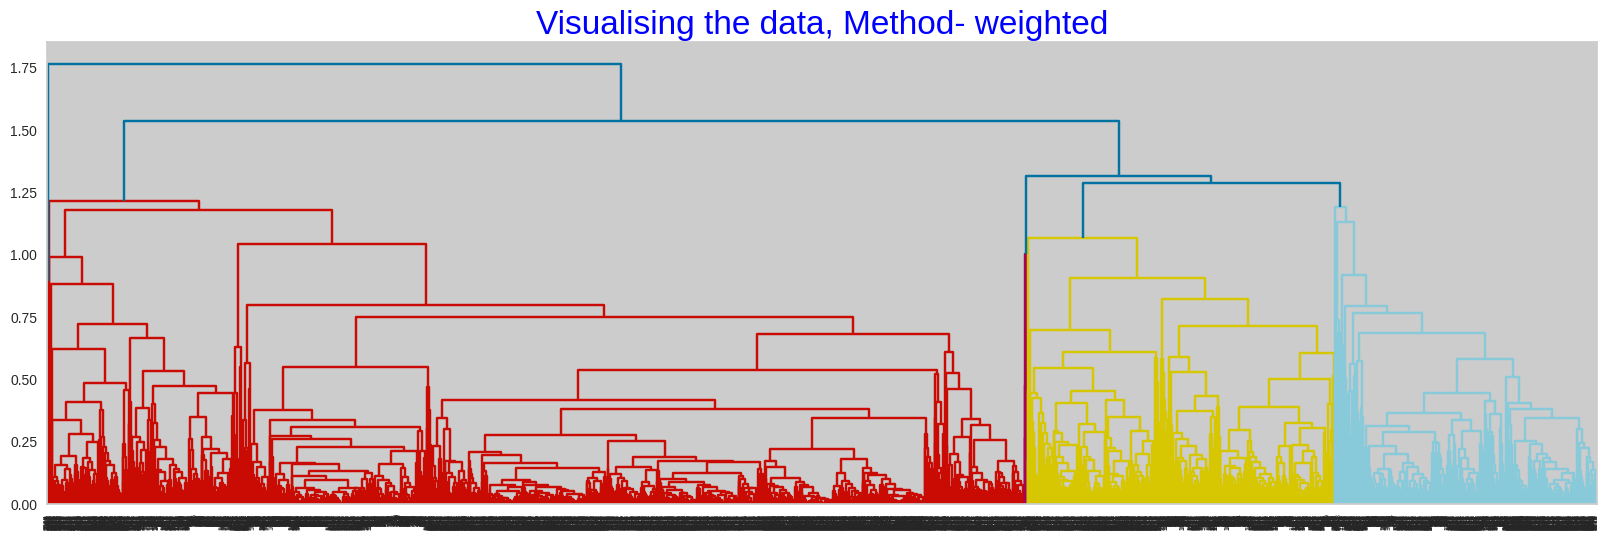

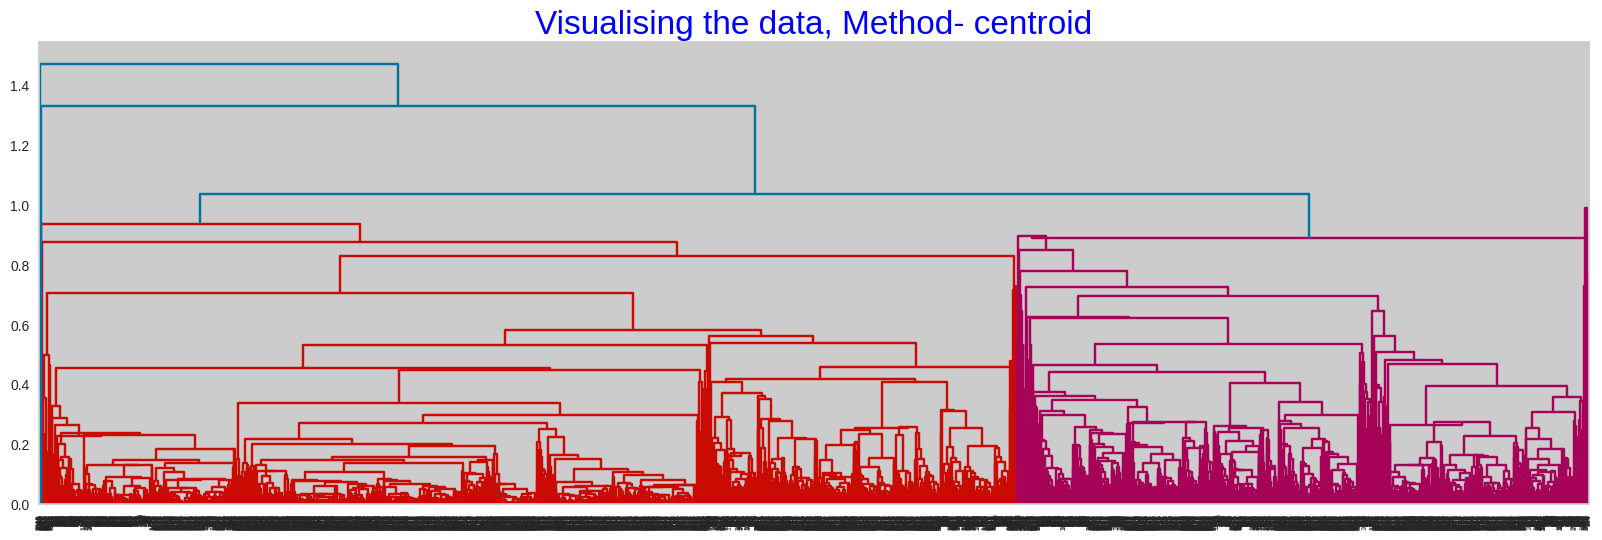

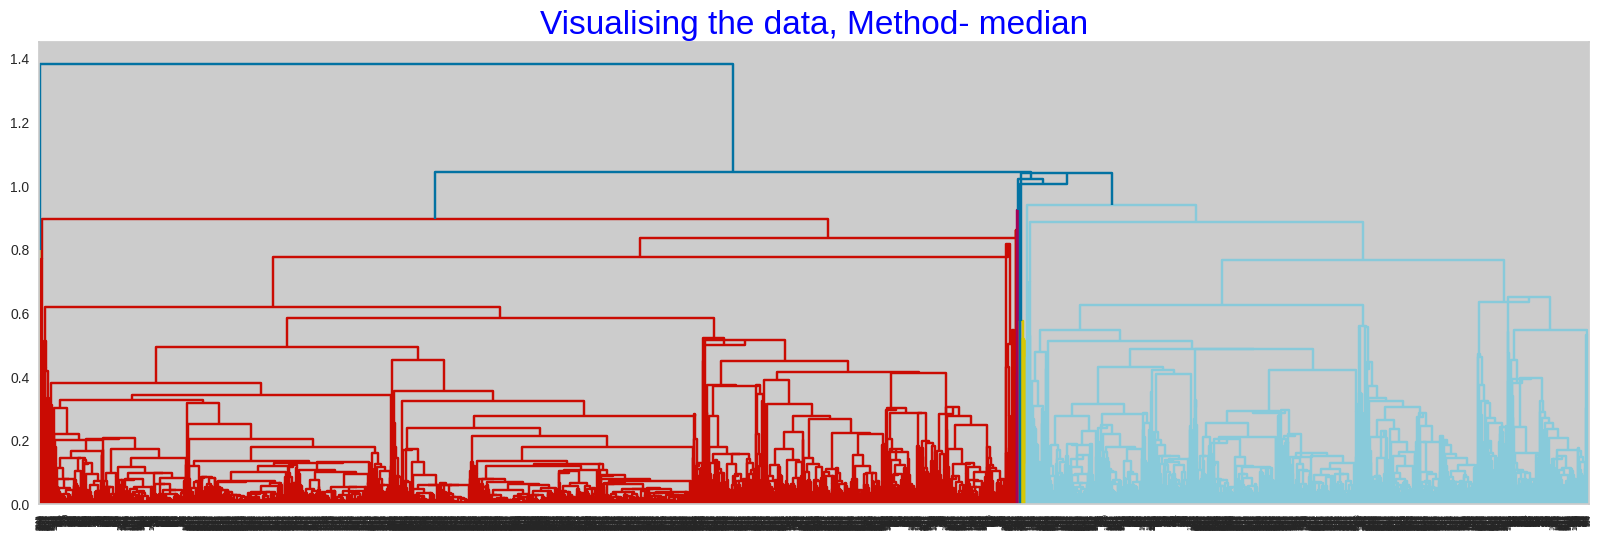

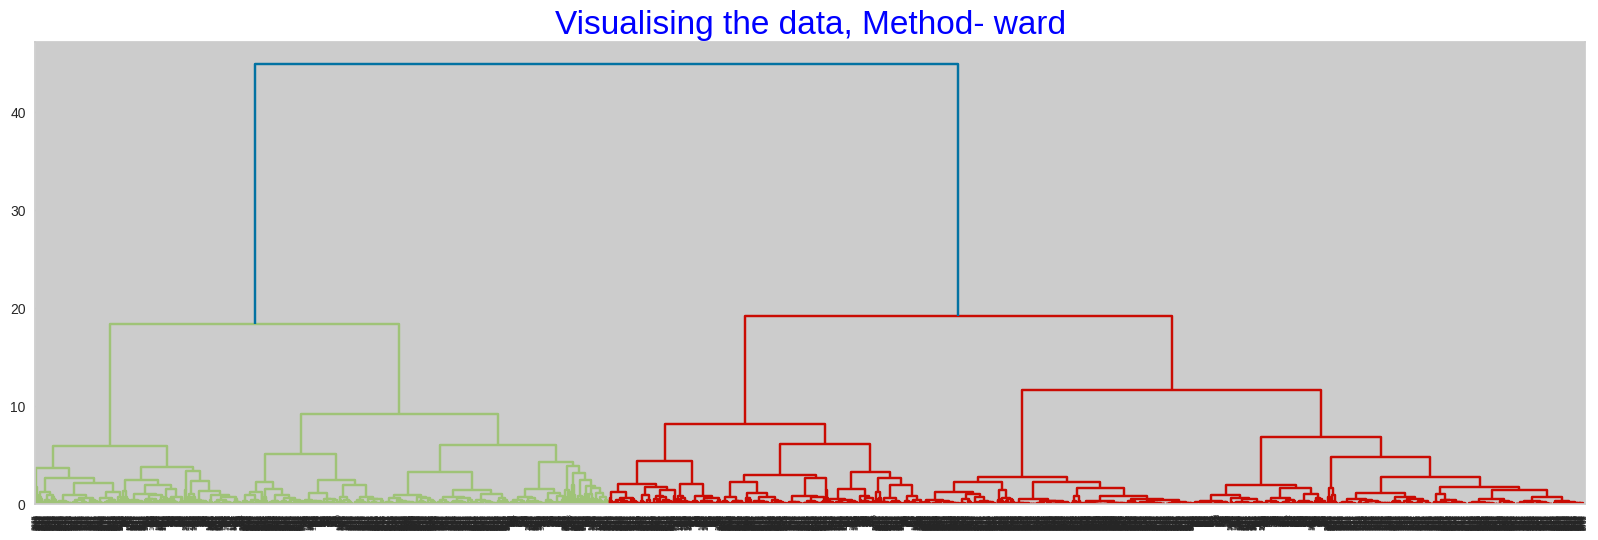

In [58]:
# Applying Dendrogram on data. Or you may apply it on Standardized/normalized indepedent variable data.
# Here diffrent linkage method from hyperparameter is used to see diff between methods for understanding. 
# Ward method is commanly used since it is simpler to visualize understanding.
# Find number of cluster's using color coding of dendrogram. Each color indicates one cluster.

for methods in ['single','complete','average','weighted','centroid','median','ward']: 
    plt.figure(figsize =(20, 6)) 
    
    dict = {'fontsize':24,'fontweight' :16, 'color' : 'blue'}
    
    plt.title('Visualising the data, Method- {}'.format(methods),fontdict = dict) 
    Dendrogram1 = sch.dendrogram(sch.linkage(minmax_df, method = methods,optimal_ordering=False))

In [59]:
n_clusters = [2,3,4,5,6,7,8]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(minmax_df)
        silhouette_score1 = sil(minmax_df, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.535930510919477
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.47040913679492186
For n_clusters = 2 The average silhouette_score with linkage- average : 0.47040913679492186
For n_clusters = 2 The average silhouette_score with linkage- single : 0.535930510919477

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.43550164891825044
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.5318787367232326
For n_clusters = 3 The average silhouette_score with linkage- average : 0.39619766243707655
For n_clusters = 3 The average silhouette_score with linkage- single : 0.5351606918177734

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.42494300944261365
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.46459708515197673
For n_clusters = 4 The average silhouette_score with linkage- average : 0.5286018409871408
F

The seperation in Ward Method indicate that 2 is the optimal number for clusters.

Ward method is actually a method that tries to minimize the variance within each cluster. In K-means when we were trying to minimize the wcss to plot our elbow method chart, here it’s almost the same the only difference is that instead of minimizing wcss we are minimizing the within-cluster variants. That is the variance within each cluster.

# 7.2 Dendrogram on Standard Scaler Applied on Data

In [60]:
n_clusters = [2,3,4,5,6,7,8,9,10]  

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(std_df)
        silhouette_score1 = sil(std_df, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.28926595242577247
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.8111134025692677
For n_clusters = 2 The average silhouette_score with linkage- average : 0.8111134025692677
For n_clusters = 2 The average silhouette_score with linkage- single : 0.8562820070415407

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.2940432062008608
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.7760836053602842
For n_clusters = 3 The average silhouette_score with linkage- average : 0.7838667595062349
For n_clusters = 3 The average silhouette_score with linkage- single : 0.7350532148998382

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.30814152852022786
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.5985727763092806
For n_clusters = 4 The average silhouette_score with linkage- average : 0.7731120442583631
For

**Conclusion**: Max score is with cluster numbers 2 in standard scaler transformation and in Min Max scaler transformation.

* Heirarchical clustering means creating a tree of clusters by iteratively grouping or separating data points. There are two types of hierarchical clustering: Agglomerative clustering Divisive clustering We now apply the Agglomerative clustering technique:Agglomerative clustering is kind of a bottom-up approach. Each data point is assumed to be a separate cluster at first. Then the similar clusters are iteratively combined

# 7.3 PCA

7.3A Running PCA of standardized data.

In [61]:
# applying PCA on std_df

# we are considering 95% variance in n_components to not loose any data.

from sklearn.decomposition import PCA
pca_std = PCA(random_state=10, n_components=0.95)
pca_std_df= pca_std.fit_transform(std_df)

In [62]:
# eigenvalues..

print(pca_std.singular_values_)

[114.62320365  83.12946351  64.9433498   63.53081811  61.96651495
  60.39644071  56.79935294  49.81594442  37.95522507]


In [63]:
# variance containing in each formed PCA

print(pca_std.explained_variance_ratio_*100)

[29.86764604 15.70962673  9.58793945  9.17539578  8.72911177  8.29236866
  7.33403008  5.64147473  3.27490761]


In [64]:
# Cummulative variance ratio..

# this will give an idea of, at how many no. of PCAs, the cummulative addition of
#........variance will give much information..

cum_variance = np.cumsum(pca_std.explained_variance_ratio_*100)
cum_variance

array([29.86764604, 45.57727277, 55.16521222, 64.340608  , 73.06971976,
       81.36208842, 88.69611851, 94.33759324, 97.61250085])

Conclusion:
by applying PCA on standardized data with 95% variance it gives 9 PCA components.

# 7.3B Silhouette Score method for PCA Standard Scaled Data

In [65]:
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(pca_std_df)
        silhouette_score1 = sil(pca_std_df, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.19974848194356434
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.8108872970217894
For n_clusters = 2 The average silhouette_score with linkage- average : 0.8108872970217894
For n_clusters = 2 The average silhouette_score with linkage- single : 0.738348693430483

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.21117381561703905
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.7784326687701913
For n_clusters = 3 The average silhouette_score with linkage- average : 0.7858157031588873
For n_clusters = 3 The average silhouette_score with linkage- single : 0.7380711786432604

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.21512158688323973
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.6685647808748002
For n_clusters = 4 The average silhouette_score with linkage- average : 0.7754755890058266
For

# 7.3C Run Hierarchical Clustering.(Agglomerative Clustering)

In [66]:
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=2)
y_pred_hie = agg_clustering.fit_predict(pca_std_df)
print(y_pred_hie.shape)
y_pred_hie

(3999,)


array([1, 1, 1, ..., 0, 1, 1])

Ward method is actually a method that tries to minimize the variance within each cluster. In K-means when we were trying to minimize the wcss to plot our elbow method chart, here it’s almost the same the only difference is that instead of minimizing wcss we are minimizing the within-cluster variants. That is the variance within each cluster.

In [67]:
# Cluster numbers

agg_clustering.n_clusters_

2

In [68]:
# Clustering Score

(sil(pca_std_df, agg_clustering.labels_)*100).round(3)

19.975

**Putting Cluster lables into original dataset And analysis of the same**

In [69]:
# Concating Labels with main dataset copy

df['Hierarchical_labels'] = agg_clustering.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,1
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,1
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,1
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,1
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,0


In [70]:
df.groupby('Hierarchical_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Hierarchical_labels,,,,,,,,,,,,,
0,1764.360227,101290.534671,249.525949,2.793284,1.000000,1.021369,27673.668993,15.607065,720.235063,2.112952,4581.034889,0.632359,0.367641
1,2351.456624,36384.825909,2.433177,1.073271,1.033998,1.000000,2993.269050,6.218640,110.354045,0.379836,3496.955451,0.018171,0.981829


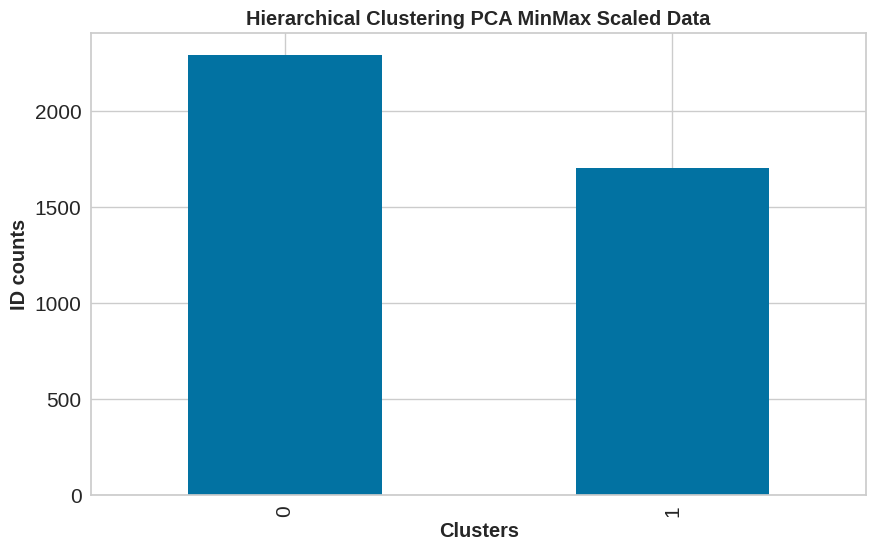

In [71]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Hierarchical_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Hierarchical Clustering PCA MinMax Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# 7.3D Running PCA of MinMaxscalar data.

In [72]:
# applying PCA on minmax_df

from sklearn.decomposition import PCA

pca_minmax =  PCA(random_state=10, n_components=0.95)
pca_minmax_df = pca_minmax.fit_transform(minmax_df)

In [73]:
# eigenvalues..

print(pca_minmax.singular_values_)

[32.61670755 20.38332523 14.95110164  6.55157753]


In [74]:
# variance containing in each formed PCA

print(pca_minmax.explained_variance_ratio_*100)

[58.10867135 22.69398556 12.20975906  2.34451208]


Conclusion:
By applying PCA on MinMaxscalr transformation data gives 4 PCA components.



# 7.3E Silhouette Score method for PCA MinMax Scaled Data

In [75]:
n_clusters = [2,3,4,5,6,7,8]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster2 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels2 = hie_cluster2.fit_predict(pca_minmax_df)
        silhouette_score2 = sil(pca_minmax_df, hie_labels2)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score2)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.5570574742349608
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.4506642023138535
For n_clusters = 2 The average silhouette_score with linkage- average : 0.4747033851497026
For n_clusters = 2 The average silhouette_score with linkage- single : 0.5570574742349608

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.4668442861396812
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.5527446133470341
For n_clusters = 3 The average silhouette_score with linkage- average : 0.5545574774683506
For n_clusters = 3 The average silhouette_score with linkage- single : 0.5558068847998209

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.46056391656489376
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.509530818047692
For n_clusters = 4 The average silhouette_score with linkage- average : 0.4979760029410702
For n

**Conclusion**: Max score is with cluster numbers 2 for ward and mostly others.

# 7.3F Run Hierarchical Clustering.(Agglomerative Clustering)

In [76]:
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_pred_hie = agg_clustering.fit_predict(pca_minmax_df)
print(y_pred_hie.shape)
y_pred_hie

(3999,)


array([0, 0, 0, ..., 1, 0, 0])

In [77]:
# Cluster numbers

agg_clustering.n_clusters_

2

In [78]:
# Clustering Score

(sil(pca_minmax_df, agg_clustering.labels_)*100).round(3)

55.706

Putting Cluster lables into original dataset And analysis of the same

In [79]:
# Concating Labels with main dataset copy

df['Hierarchical_labels'] = agg_clustering.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,1


In [80]:
df.groupby('Hierarchical_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Hierarchical_labels,,,,,,,,,,,,,
0,2173.169182,59807.839555,87.602462,1.705322,1.01390,1.008737,10227.689039,9.142971,226.292295,0.652502,3820.652105,0.0,1.0
1,1745.592843,97053.051317,240.196489,2.661715,1.01553,1.018231,28905.414585,15.782579,857.501013,2.599595,4625.062120,1.0,0.0


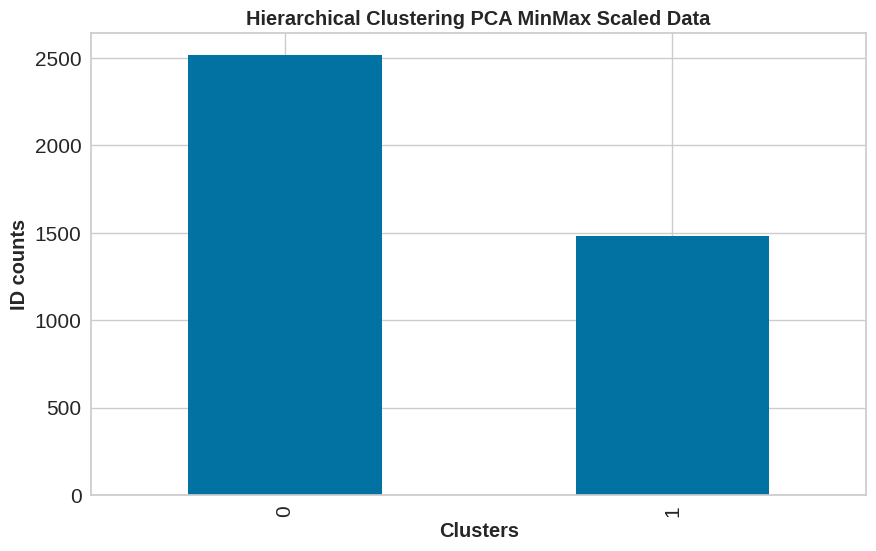

In [81]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Hierarchical_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Hierarchical Clustering PCA MinMax Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# 8. DBSCAN - (Density Based Spatial Clustering of Applications with Noise)

**8.1 DBSCAN of Standard Scaled Data**

To choose the best combination of the algorithm parameters I will first create a matrix of investigated combinations.

In [83]:
from itertools import product

eps_values = np.arange(0.25,3,0.25) # eps values to be investigated
min_samples = np.arange(3,23) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

In [84]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(std_df)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(std_df, DBS_clustering.labels_))

A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.


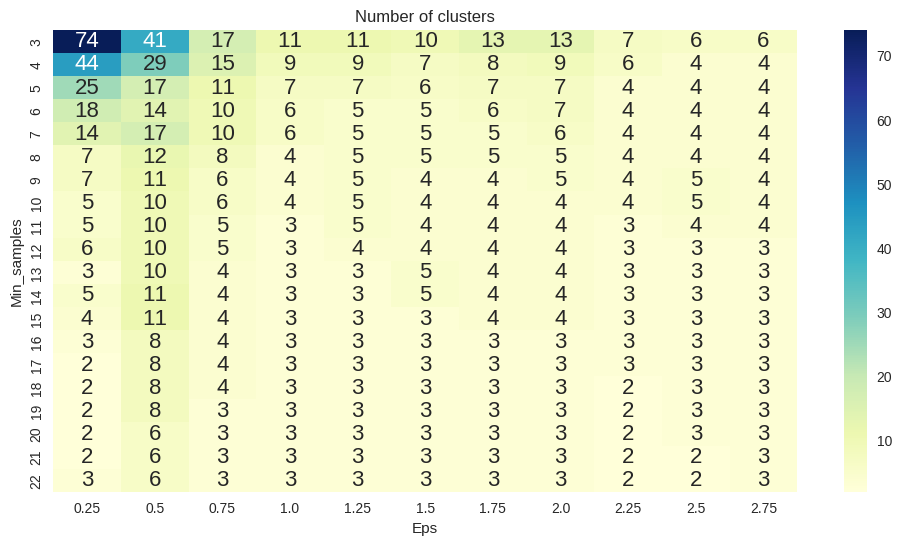

In [85]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
print('A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.')
plt.show()

As the heatplot above shows, the number of clusters vary from 74 to 2.

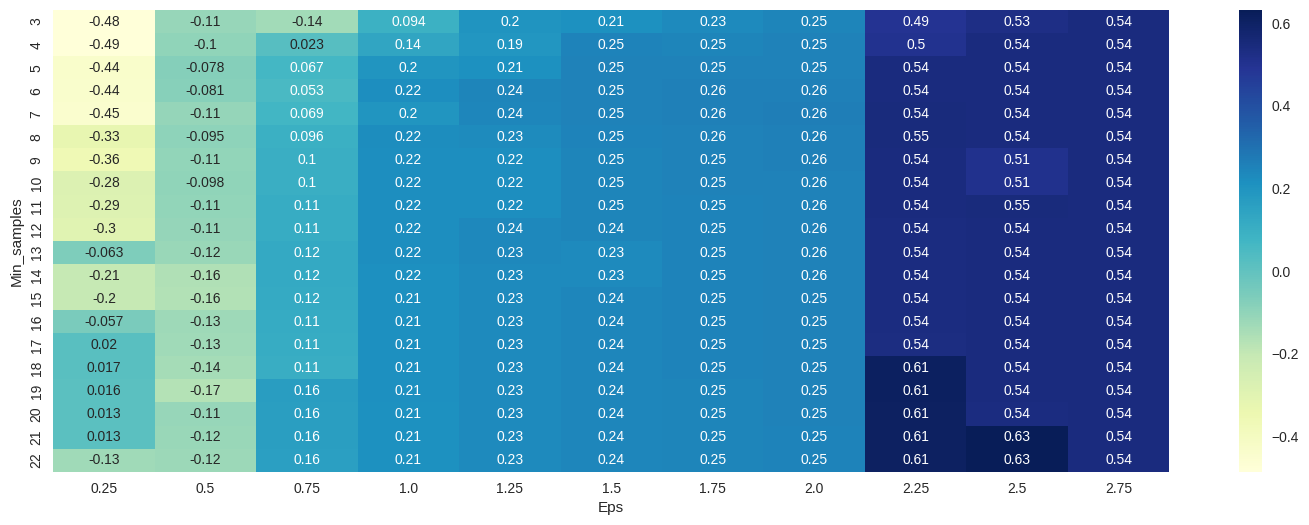

In [86]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Global maximum is 0.63 for eps=2.5 and min_samples=21 and 22

In [87]:
epsilon = [0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75]
min_samples = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]


sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(std_df)
        #cluster_labels=dbscan.fit_predict(data) 
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        silhouette_avg = sil(std_df, labels)
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0], 
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 2.5 
min_sample= 21 
number of clusters= 1 
average silhouette score= 0.6319


Run DBSCAN on Standard Scaled data with optimal min_sample and epsilon values

In [88]:
dbscan = DBSCAN(eps=2.5, min_samples=21)
dbscan.fit(std_df)

DBSCAN(eps=2.5, min_samples=21)

In [89]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0])

-1 are the noise points in our dataset and the rest are the clusters

In [90]:
# Concating Labels with main dataset copy

df['DBSCAN_labels'] = dbscan.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels,DBSCAN_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,0,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,0,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,0,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,0,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,1,0


In [91]:
df.groupby('DBSCAN_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
DBSCAN_labels,,,,,,,,,,,,,,
-1,1708.947115,211990.889423,1522.576923,2.509615,1.278846,1.235577,45335.081731,24.754808,3276.389423,9.548077,4768.596154,0.687500,0.312500,0.687500
0,2031.601688,66008.336587,68.482722,2.034819,1.000000,1.000000,15598.138486,10.880243,305.532577,0.925086,4082.893959,0.352941,0.647059,0.352941


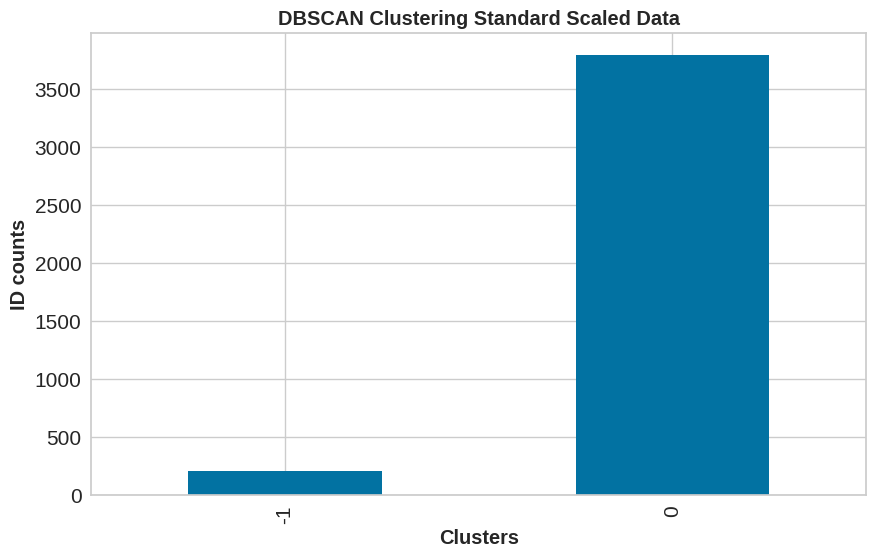

In [92]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['DBSCAN_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('DBSCAN Clustering Standard Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

8.2 DBSCAN on MinMax Scaled Data

To choose the best combination of the algorithm parameters  we first create a matrix of investigated combinations.


In [93]:
from itertools import product

eps_values = np.arange(0.25,1.25,0.25) # eps values to be investigated
min_samples = np.arange(3,23) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

In [94]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(minmax_df)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(minmax_df, DBS_clustering.labels_))

Collecting number of generated clusters.

A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.


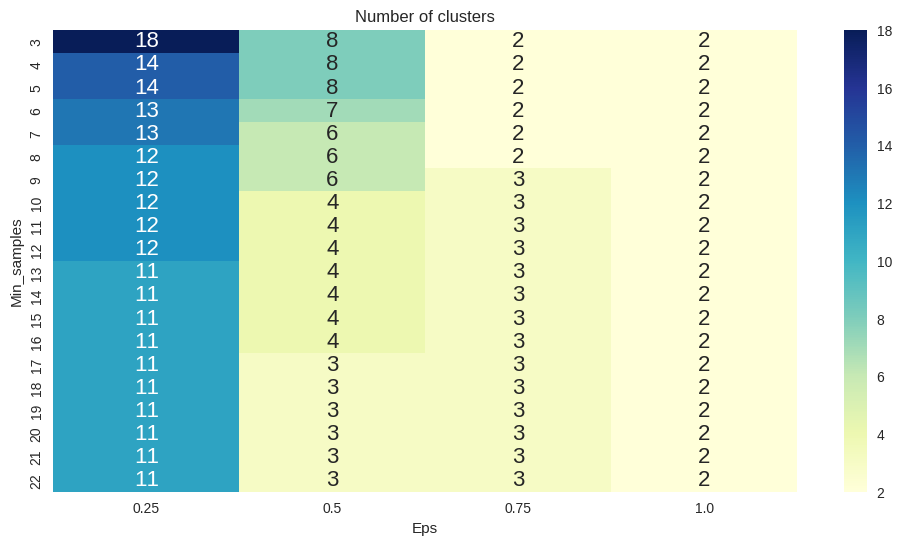

In [95]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
print('A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.')
plt.show()

As the heatplot above shows, the number of clusters vary from 18 to 2.

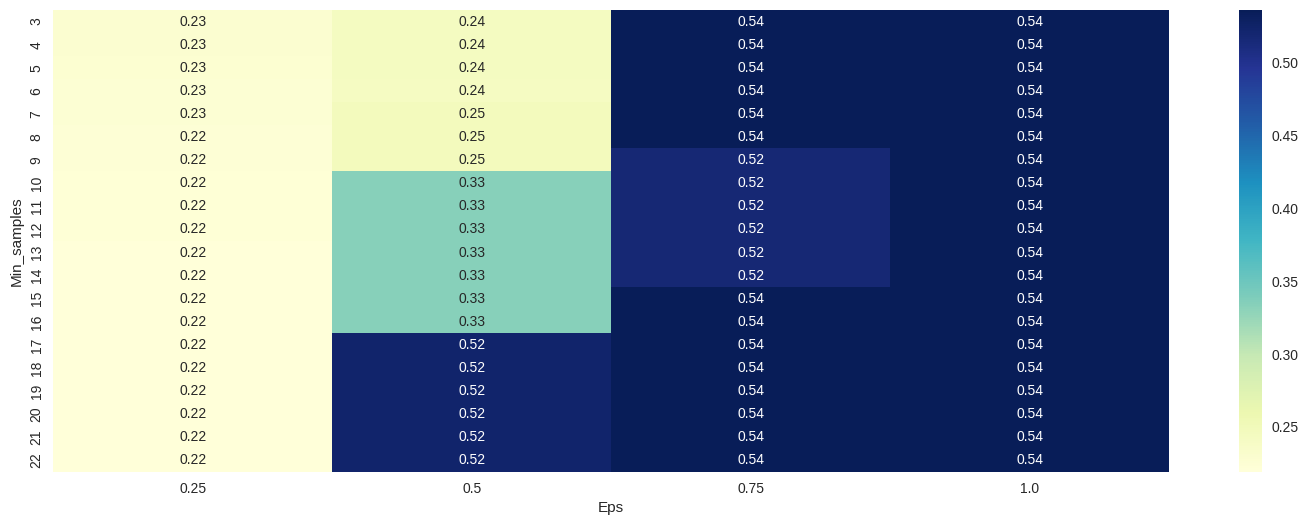

In [96]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Global maximum is 0.54 for eps=1.0 and min_samples=from 22 to 3

In [97]:
epsilon = [0.25,0.5,0.75,1]
min_samples = [11,12,13,14,15,16,17,18,19,20,21,22]


sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(minmax_df)
        #cluster_labels=dbscan.fit_predict(data) 
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        silhouette_avg = sil(minmax_df, labels)
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0], 
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 1 
min_sample= 11 
number of clusters= 2 
average silhouette score= 0.5359


In [98]:
epsilon = [0.25,0.5,0.75,1]
min_samples = [3,4,5,6,7,8,9,10,11]


sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(minmax_df)
        #cluster_labels=dbscan.fit_predict(data) 
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        silhouette_avg = sil(minmax_df, labels)
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0], 
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 0.75 
min_sample= 3 
number of clusters= 2 
average silhouette score= 0.5359


Run DBSCAN on MinMax Scaled data with optimal min_sample and epsilon values

In [99]:
dbscan = DBSCAN(eps=1, min_samples=22) # min_samples = number of clumns * 3
dbscan.fit(minmax_df)

DBSCAN(eps=1, min_samples=22)

In [100]:
dbscan.labels_

array([0, 0, 0, ..., 1, 0, 0])

-1 are the noise points in our dataset and the rest are the clusters

In [101]:
# Concating Labels with main dataset copy

df['DBSCAN_labels'] = dbscan.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels,DBSCAN_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,0,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,0,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,0,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,0,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,1,1


In [102]:
df.groupby('DBSCAN_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
DBSCAN_labels,,,,,,,,,,,,,,
0,2173.169182,59807.839555,87.602462,1.705322,1.01390,1.008737,10227.689039,9.142971,226.292295,0.652502,3820.652105,0.0,1.0,0.0
1,1745.592843,97053.051317,240.196489,2.661715,1.01553,1.018231,28905.414585,15.782579,857.501013,2.599595,4625.062120,1.0,0.0,1.0


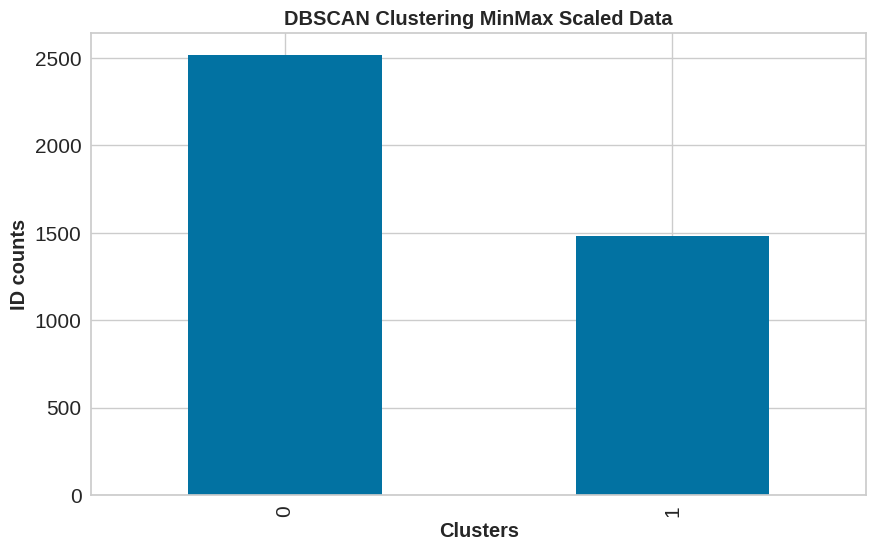

In [103]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['DBSCAN_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('DBSCAN Clustering MinMax Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

**Conclusion**:

In cluster number 0 & 1 there are more customers. Need to focus on cluster 0 & 1.

In [104]:
# Sorting elements based on cluster label assigned and taking average for insights.

cluster1 = pd.DataFrame(df.loc[df.DBSCAN_labels==0].mean(),columns= ['Cluster1_avg'])
cluster2 = pd.DataFrame(df.loc[df.DBSCAN_labels==1].mean(),columns= ['Cluster2_avg'])

In [105]:
avg_df = pd.concat([cluster1,cluster2],axis=1)
avg_df

,Cluster1_avg,Cluster2_avg
ID,2173.169182,1745.592843
Balance,59807.839555,97053.051317
Qual_miles,87.602462,240.196489
cc1_miles,1.705322,2.661715
cc2_miles,1.013900,1.015530
cc3_miles,1.008737,1.018231
Bonus_miles,10227.689039,28905.414585
Bonus_trans,9.142971,15.782579
Flight_miles_12mo,226.292295,857.501013
Flight_trans_12,0.652502,2.599595


**Conclusion** :

As decided need to focous on first two clusters.. Considering past Award status(0 or 1) cluster number2 shows award avg as 1 that means people awarded with scheme. Similarly for cluster number 2 award avg. is 0. Since avg is low that means now maximim award given to cluster number1 in the past. Need to add future schemes for cluster number two members on different bonus points & different card transaction bonus.

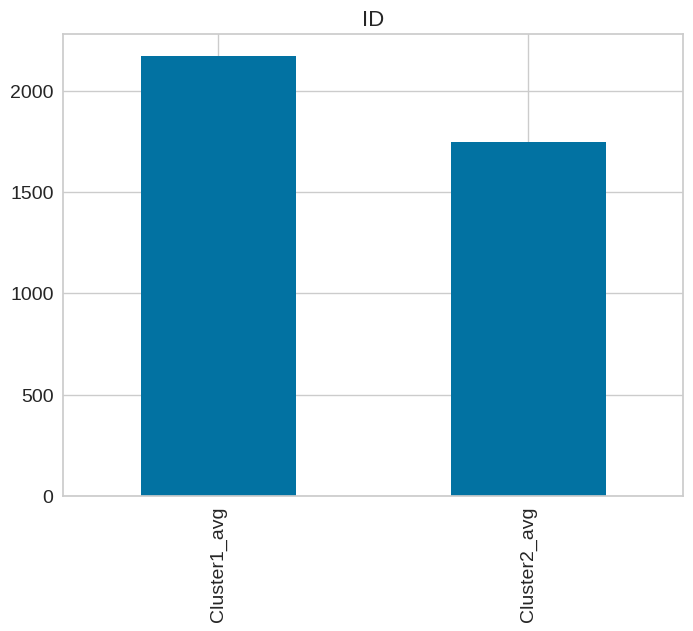

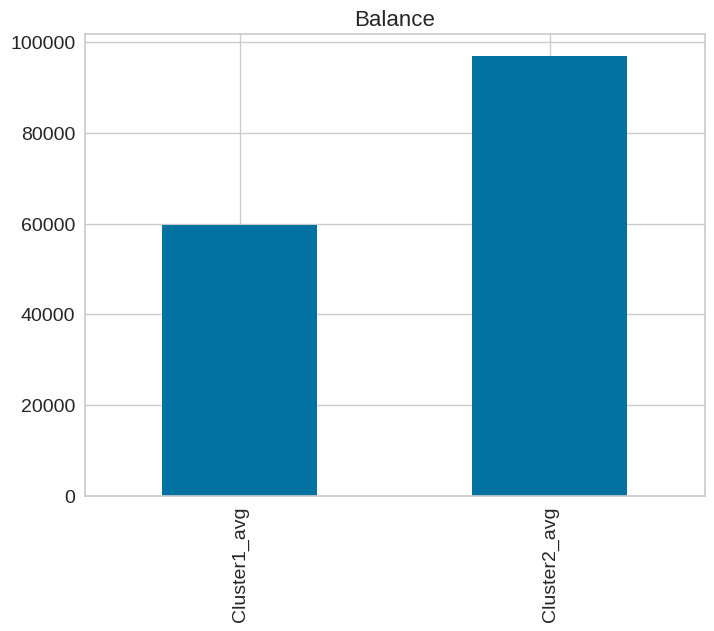

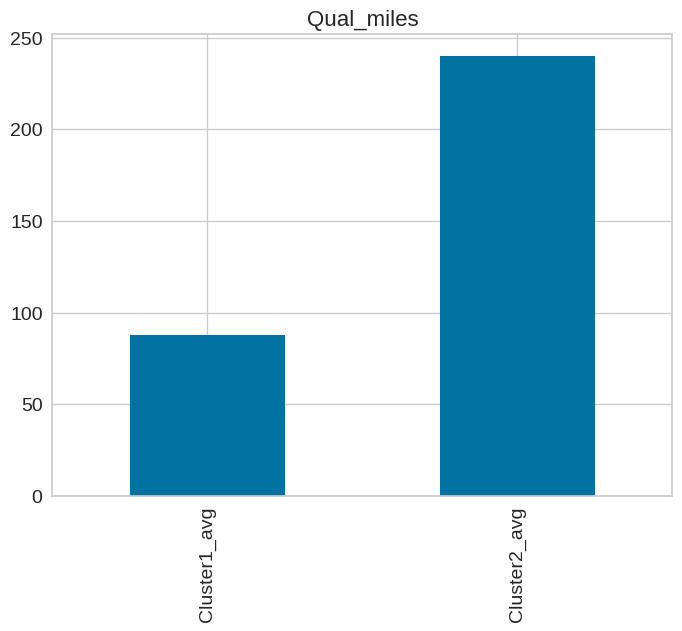

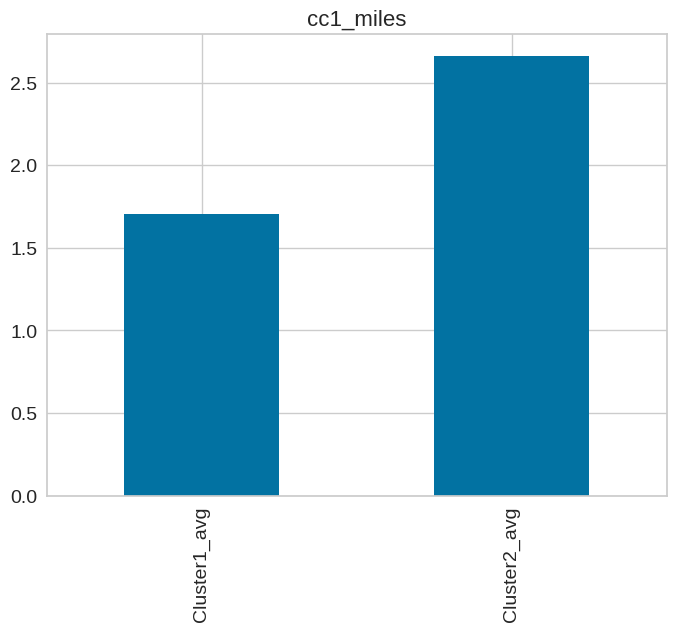

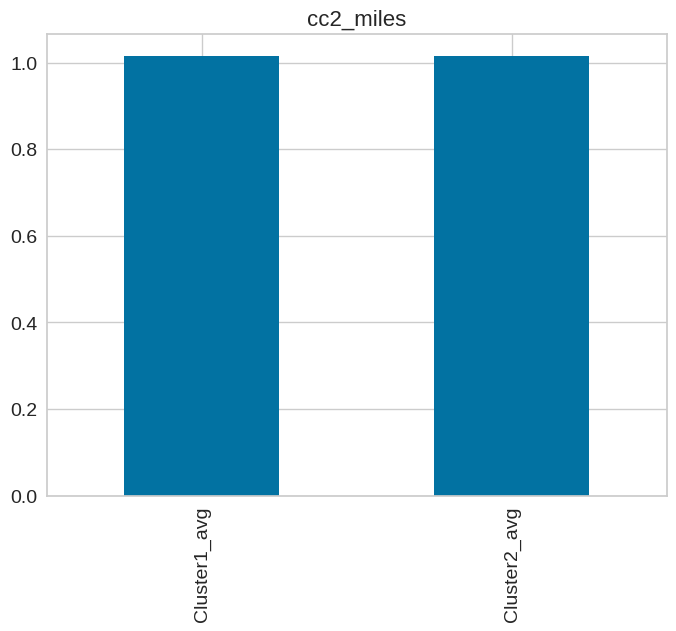

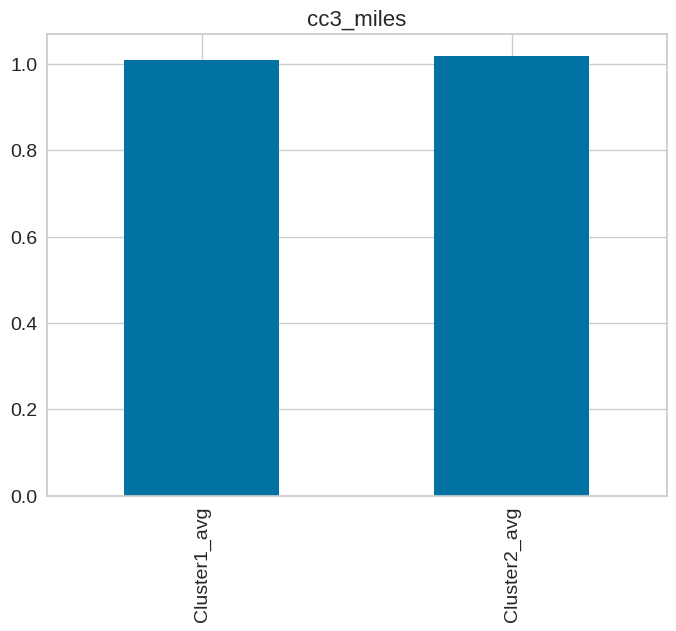

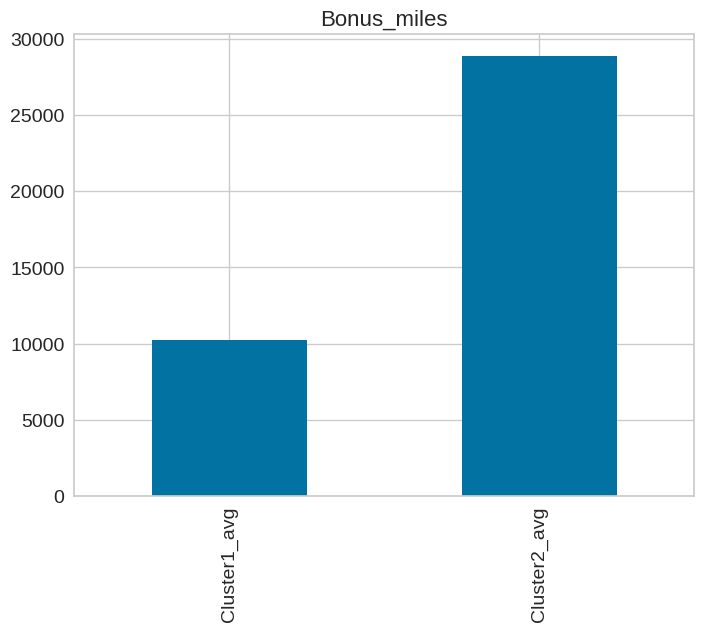

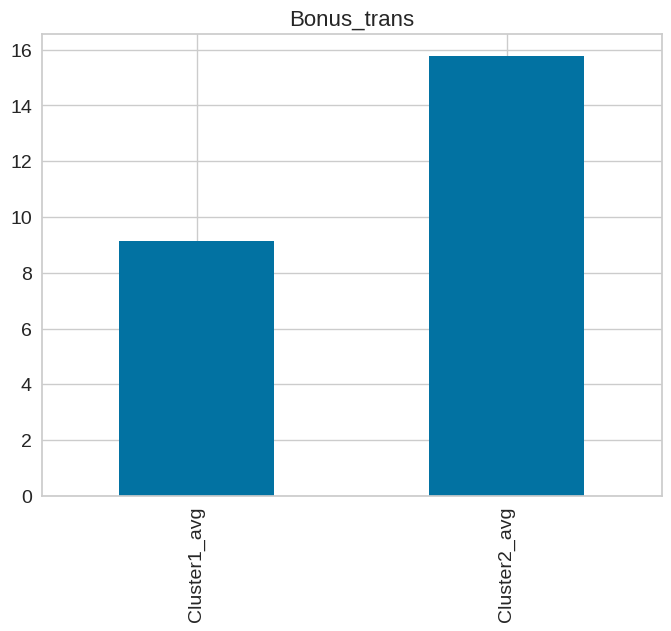

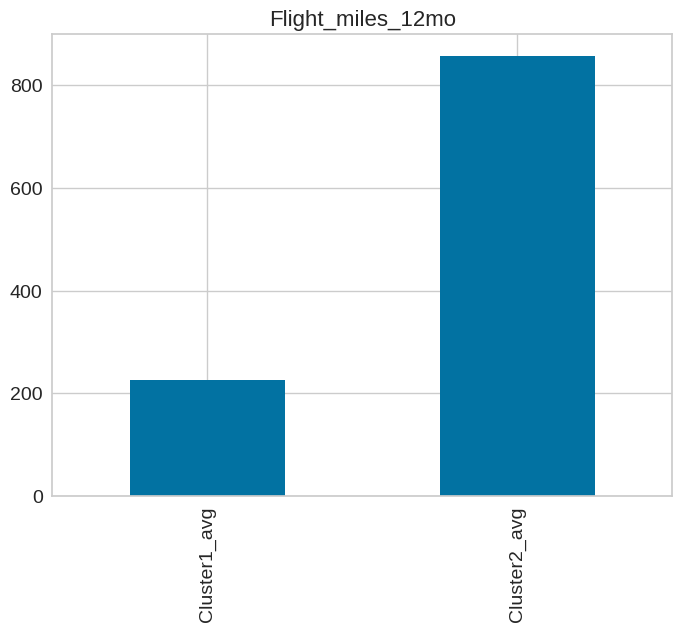

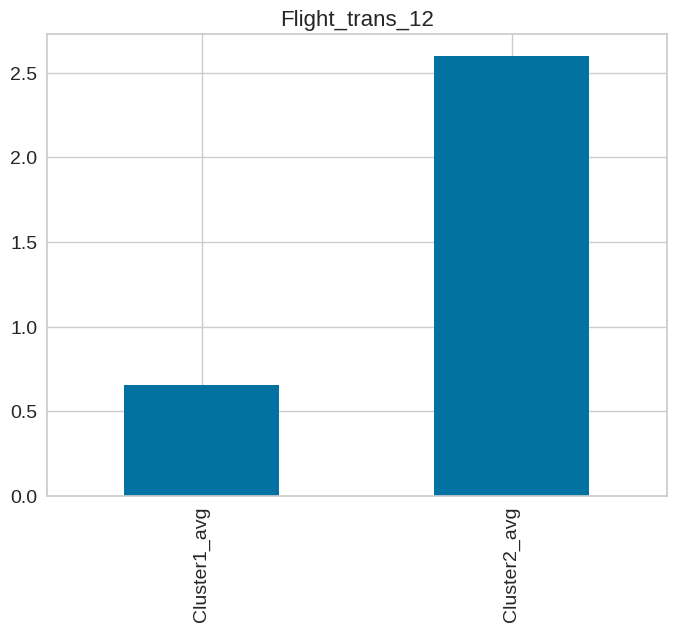

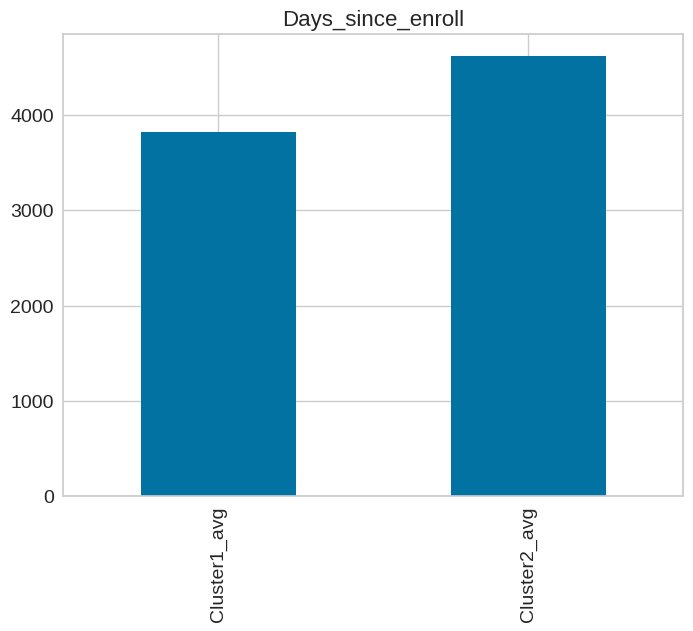

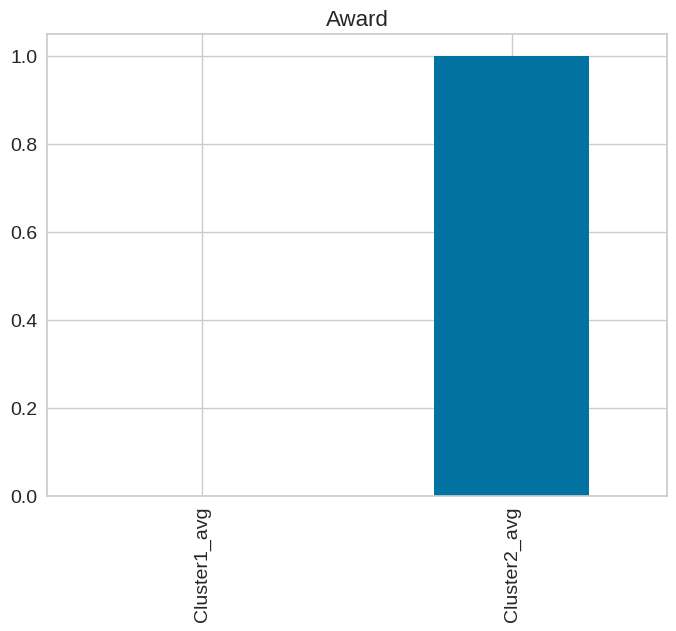

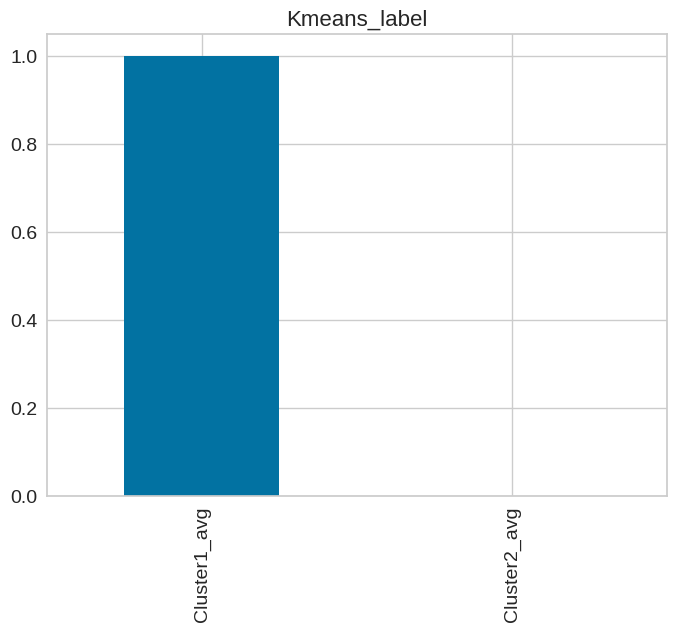

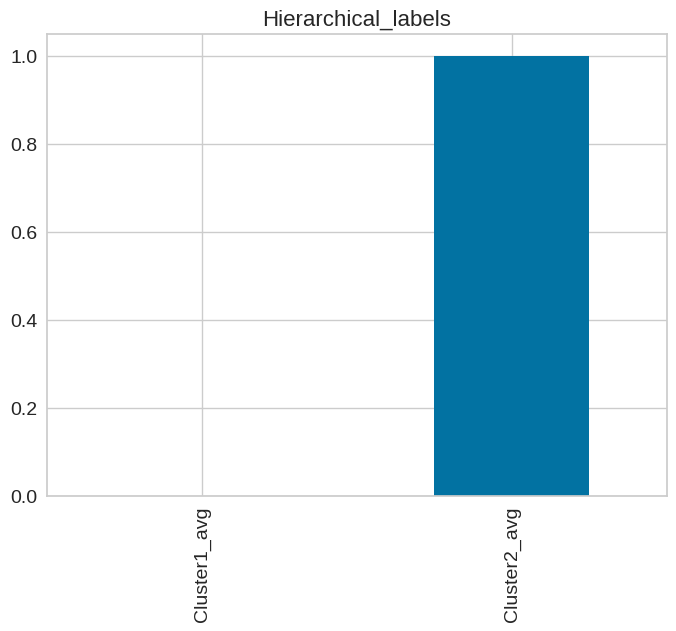

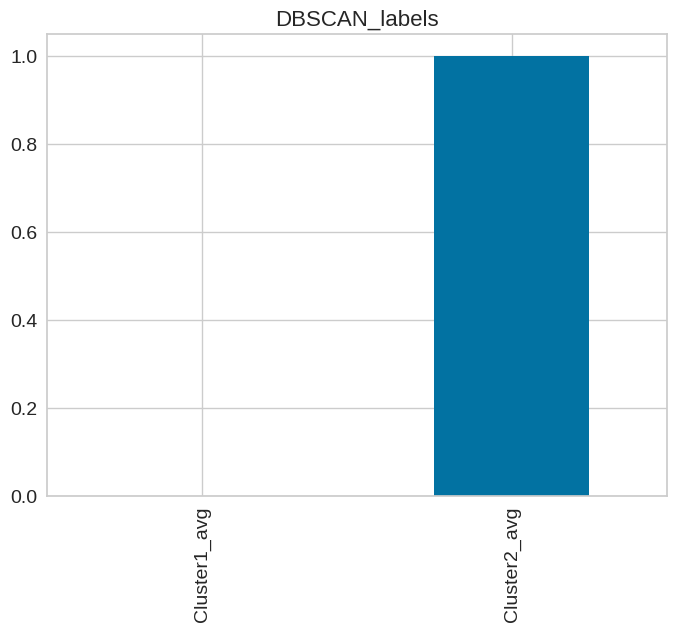

In [106]:
# Extract and plot one Column data .xs method
for i , row in avg_df.iterrows():
    fig = plt.subplots(figsize=(8,6))
    j = avg_df.xs(i ,axis = 0)
    plt.title(i, fontsize=16, fontweight=20)
    j.plot(kind='bar',fontsize=14)
    plt.show()
    print()

# 9. Conclusion:

Applied EDA to analyze dataset.Discovered correlation between diff variables and found colinearity.
Applied Standardazation & MinMaxScalar transformation on the data to use Principle componets analysis effectively.
I have used & analyzed two clustering techniques here..i) KMeans, ii) Hierarchical Clusterig & iii) DBSCAN.
By applying clustering on diff. PCA obtained with diff transformation data shows fluctuation in model score. So finally the Standard Scaler found less score so not used for further model building.
KMeans clustering is sensitive to outliers